In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
train_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
#TotalSF （TotalBsmtSF + 1stFlrSF + 2ndFlrSF） の追加ように下記を作成8月２３日
train_df2  = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
#行数の表示制限を解除
pd.set_option('display.max_rows', None)
#列数の表示制限を解除
pd.set_option('display.max_columns', None)
#表示が膨大になるので、必ず head()を設定すること。
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 0 目的変数の分布図を確認して、正規分布によっているかどうか対数変換などで整形はいるか？ などを判断

In [3]:
# plt.figure(figsize=(12, 5))

# # 左側のプロット：変換前のヒストグラム
# plt.subplot(1, 2, 1)
# sns.histplot(train_df['SalePrice'], kde=True)
# plt.title('Before SalePrice plots')
# plt.xlabel('SalePrice')
# plt.ylabel('度数')

## train_df SalePrice の対数変換前のバックアップ

In [4]:
#実践的な判断フロー
#計算: 特徴量の歪度を計算する (.skew())。
#閾値チェック: 絶対値が 0.5 や 1.0 を超えているか確認する。
#性質チェック: それは変換可能な「連続値」か？ (OverallQual のようなものではないか？)
#可視化: ヒストグラムで分布の形を目で見て確認する。
#実験: 変換した場合としない場合で、モデルの精度を比較してみる。
#この多角的な視点を持つことが、より精度の高いモデルを作成するための鍵となります。

In [5]:
#明確な黄金律（ゴールデンルール）はありませんが、データサイエンスの実務でよく用いられる経験則としての一般的な目安は以下の通りです。
#歪度の目安と対数変換の判断基準
#歪度は、正負両方の値を取りうるため、絶対値で判断するのが一般的です。
#| 歪度の絶対値 (|skew|) | 評価 | 対数変換の必要性 |
#| :--- | :--- | :--- |
#| 0.5 以下 | ほぼ対称 (Approximately Symmetric) | 原則として不要です。変換による改善効果はほとんど期待できません。 |
#| 0.5 ～ 1.0 | 中程度に歪んでいる (Moderately Skewed) | 検討の価値あり。変換によってモデルの性能が向上する可能性があります。特に線形モデルを使う場合は有効なことが多いです。 |
#| 1.0 より大きい | 強く歪んでいる (Highly Skewed) | 強く推奨されます。変換しないと、外れ値の影響を強く受けたり、モデルの仮定（正規性など）から外れたりして、精度が悪化する可能性が高いです。 |
#Kaggleの住宅価格データ（train.csv）で例を見てみましょう。
#SalePrice の歪度: 約 1.88
#これは 1.0 を大幅に超えており、「強く歪んでいる」に該当します。そのため、対数変換やYeo-Johnson変換が非常に効果的です。
#GrLivArea の歪度: 約 1.37
#これも 1.0 を超えているため、変換の対象として有力な候補となります。
#OverallQual の歪度: 約 -0.22
#絶対値が 0.5 以下なので、「ほぼ対称」と判断できます。この数値からも、この特徴量に歪み補正は不要であることがわかります。

In [6]:
#結果の表示と解釈: 計算した歪度の値を表示し、その値が一般的にどのように解釈されるかの目安も表示するようにしました。
#歪度が0に近い: 分布が左右対称（正規分布など）に近いことを意味します。
#歪度が正の値: 分布の山が左に寄り、右側に裾が長く伸びている（右に歪んだ）分布です。平均値が中央値よりも大きくなる傾向があります。SalePrice はこの典型例です。
#歪度が負の値: 分布の山が右に寄り、左側に裾が長く伸びている（左に歪んだ）分布です。

# --- 1. 'OverallQual' の歪度を計算 ---
skewness = train_df['SalePrice'].skew()


# --- 2. 結果の表示 ---
print(f" SalePriceの歪度: {skewness:.4f}")
print("-----------------------------------------")


# --- 歪度の解釈 ---
print("【歪度の目安】")
if -0.5 <= skewness <= 0.5:
    print(" -> ほぼ左右対称な分布です。")
elif skewness > 0.5:
    print(" -> 右に裾が長い（右に歪んだ）分布です。")
else: # skewness < -0.5
    print(" -> 左に裾が長い（左に歪んだ）分布です。")

 SalePriceの歪度: 1.8829
-----------------------------------------
【歪度の目安】
 -> 右に裾が長い（右に歪んだ）分布です。


In [7]:
#1460ID（行）と、81カラム（列）とわかる。
train_df.shape

(1460, 81)

In [8]:
#1460IDの（行）が、1460とわかる。
len(train_df)

1460

In [9]:
train_df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object


### 見かけだけでカラムのデータを判断しないように、まずはカラムの種類を調べる

In [10]:
#データフレームの中身の種類を確認するときは、必ずすべてを確認するために、
#行数の表示制限を解除　pd.set_option('display.max_rows', None)
#列数の表示制限を解除　pd.set_option('display.max_columns', None)
#の表示制限解除が必要となる場合がある。

## 欠損値の確認

In [11]:
#ベースライン用に、まずは欠損値がないものを探す。
print(train_df.isnull().sum())

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType        872
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

## 特徴量のデータ型の確認

In [12]:
#欠損値がないかつカラムのデータ型を確認する。（RMSEの場合、object型は扱えない)
train_df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object


## 学習用データ全体とテストデータ全体のバックアップ

In [13]:
#testデータの読み込みと。ID数とカラム数を表示をさせている
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
#TotalSF （TotalBsmtSF + 1stFlrSF + 2ndFlrSF） の追加用で下記を作成した。
test2 = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
test.shape

(1459, 80)

In [14]:
train_df_backup = train_df.copy()
test_backup = test.copy()

## 特徴量の選択

In [15]:
#以下、あたりをつけた特徴量
features=["SaleCondition", "FullBath", "SaleType", "Functional", "MSZoning", "Neighborhood", "LotArea", "MSSubClass", "TotRmsAbvGrd", "GrLivArea", "1stFlrSF", "OverallQual", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinSF1", "HeatingQC", "CentralAir", "KitchenAbvGr", "KitchenQual", "ExterQual", "GarageCars", "GarageArea", "OverallCond"]
#目的変数y_train と説明変数x_trainに分けた。ここは、まだベースラインなのでドメイン知識と欠損値がないという理由だけの説明変数の選択。
x_train = train_df[features]
y_train = train_df["SalePrice"]

print(x_train.shape)
print(y_train.shape)

(1460, 25)
(1460,)


### featuresのバックアップ

In [16]:
# featuresのバックアップOverallQualの追加とHeatingの削除
#↓
#features_back_up_0810 = features 
#FullBath の追加
#↓
#features_back_up_0812 = features

#YearBuilt、YrSold の追加
#↓
#features_back_up_0813 = features

In [17]:
features

['SaleCondition',
 'FullBath',
 'SaleType',
 'Functional',
 'MSZoning',
 'Neighborhood',
 'LotArea',
 'MSSubClass',
 'TotRmsAbvGrd',
 'GrLivArea',
 '1stFlrSF',
 'OverallQual',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'HeatingQC',
 'CentralAir',
 'KitchenAbvGr',
 'KitchenQual',
 'ExterQual',
 'GarageCars',
 'GarageArea',
 'OverallCond']

## 特徴量選択後のテストデータの定義

In [18]:
#X_test を事前に読み込んだ特徴量の数（features)と設定し、表示させている。

x_test = test[features]
x_test.shape

(1459, 25)

## 特徴量選択後の学習用データとテストデータのバックアップ

In [19]:
# x_train_backup = x_train.copy()

In [20]:
# x_test_backup = x_test.copy()

## 特徴量 の順序付きマッピング ＠＠最初に欠損値と種類はデータフレームを作成して一覧できる！とにかく時間を短縮できそうならする！

#### 特徴量選択後の学習用データの欠損値を調べる。

In [21]:
#データフレームで、選択した特徴量の欠損件数等をあらかじめ表示させる

# missing_info = pd.DataFrame({
#     '欠損件数': x_train_backup[features].isnull().sum(),
#     '欠損率': x_train_backup[features].isnull().mean()
# })

# # 欠損があるカラムだけ表示（任意）
# missing_info = missing_info[missing_info['欠損件数'] > 0]
# missing_info = missing_info.sort_values(by='欠損率', ascending=False)

# missing_info

#### 特徴量選択後のテストデータの欠損値を調べる。（欠損値への処理は学習用、テスト用ともに必要なので、かならずどちらも欠損値を確認する）

In [22]:
# missing_info = pd.DataFrame({
#     '欠損件数': x_test_backup[features].isnull().sum(),
#     '欠損率': x_test_backup[features].isnull().mean()
# })

# # 欠損があるカラムだけ表示（任意）
# missing_info = missing_info[missing_info['欠損件数'] > 0]
# missing_info = missing_info.sort_values(by='欠損率', ascending=False)

# missing_info

#### 選択した特徴量の種類とそのサンプル値を確認する。（学習用データ）

In [23]:
# #pandas のデフォルト表示幅制限を解除↓

# summary = pd.DataFrame({
#     '種類数': [x_train_backup[col].nunique(dropna=True) for col in features],
#     'サンプル値': [x_train_backup[col].dropna().unique()[:13] for col in features]  # 最大5種表示
#     }, index=features)

    
# with pd.option_context('display.max_colwidth', None):
#     display(summary)



#### 選択した特徴量の種類とそのサンプル値を確認する。（テストデータ）

In [24]:
# #pandas のデフォルト表示幅制限を解除↓
# summary = pd.DataFrame({
#     '種類数': [x_test_backup[col].nunique(dropna=True) for col in features],
#     'サンプル値': [x_test_backup[col].dropna().unique()[:13] for col in features]  # 最大5種表示
# }, index=features)

# with pd.option_context('display.max_colwidth', None):
#     display(summary)


# summary

#### Heating QC のマッピング

In [25]:
# ##学習用データの型と値の種類を確認する
# print(x_train['HeatingQC'].dtype)
# print(x_train['HeatingQC'].unique())

In [26]:
# #テスト用データの型と値の種類を確認する
# print(x_test['HeatingQC'].dtype)
# print(x_test['HeatingQC'].unique())

In [27]:
heatingQC_order = {
    'Ex': 4,
    'Gd': 3,
    'TA': 2,
    'Fa': 1,  
    "Po": 0,
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['HeatingQC'] = x_train['HeatingQC'].map(heatingQC_order)
x_test['HeatingQC'] = x_test['HeatingQC'].map(heatingQC_order)

In [28]:
# missing_count = x_train['HeatingQC'].isna().sum()
# print(f"'HeatingQC' の欠損値件数: {missing_count} 件")

In [29]:
# missing_count = x_test['HeatingQC'].isna().sum()
# print(f"'HeatingQC' の欠損値件数: {missing_count} 件")

#### CentralAir	のマッピング

In [30]:
# ##学習用データの型と値の種類を確認する
# print(x_train['CentralAir'].dtype)
# print(x_train['CentralAir'].unique())

In [31]:
# ##テスト用データの型と値の種類を確認する
# print(x_test['CentralAir'].dtype)
# print(x_test['CentralAir'].unique())

In [32]:
CentralAir_order = {
    'Y': 1,
    'N': 0,
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['CentralAir'] = x_train['CentralAir'].map(CentralAir_order)
x_test['CentralAir'] = x_test['CentralAir'].map(CentralAir_order)

In [33]:
# missing_count = x_train['CentralAir'].isna().sum()
# print(f"'CentralAir' の欠損値件数: {missing_count} 件")

In [34]:
# missing_count = x_test['CentralAir'].isna().sum()
# print(f"'CentralAir' の欠損値件数: {missing_count} 件")

#### Heating,Heating QC ,CentralAir のマッピング後のバックアップ(0709)

In [35]:
# x_train_backup0709 = x_train.copy()
# x_test_backup0709 = x_test.copy()

#### BsmtCondのマッピング（欠損値 train,test ともに欠損値あり）欠損値を補完したあとでないと、型の変換はできない

In [36]:
# ##学習用データの型と値の種類を確認する
# print(x_train['BsmtCond'].dtype)
# print(x_train['BsmtCond'].unique())

In [37]:
# ##テスト用データの型と値の種類を確認する
# print(x_test['BsmtCond'].dtype)
# print(x_test['BsmtCond'].unique())

In [38]:
#BsmtCond
#[TA, Po, Fa, Gd]

BsmtCond_order = {
    'Gd': 3,
    'TA': 2,
    'Fa': 1,  
    "Po": 0,
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['BsmtCond'] = x_train['BsmtCond'].map(BsmtCond_order)
x_test['BsmtCond'] = x_test['BsmtCond'].map(BsmtCond_order)

In [39]:
# missing_count = x_train['BsmtCond'].isna().sum()
# print(f"'BsmtCond' の欠損値件数: {missing_count} 件")

In [40]:
# missing_count = x_test['BsmtCond'].isna().sum()
# print(f"'BsmtCond' の欠損値件数: {missing_count} 件")

#### Heating,Heating QC,CentralAir,BsmtCond のマッピング後のバックアップ(0709_1)¶

In [41]:
# x_train_backup0709_1 = x_train.copy()
# x_test_backup0709_1 = x_test.copy()

#### KitchenAbvGrのマッピングint 型なので、キーとマップをintでそろえること

In [42]:
# ###学習用データの型と値の種類を確認する
# print(x_train['KitchenAbvGr'].dtype)
# print(x_train['KitchenAbvGr'].unique())

In [43]:
# ###テスト用データの型と値の種類を確認する
# print(x_test['KitchenAbvGr'].dtype)
# print(x_test['KitchenAbvGr'].unique())

In [44]:
KitchenAbvGr_order = {
     1: '2',
     2: '1',
     3: '1',  
     0: '0',
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['KitchenAbvGr'] = x_train['KitchenAbvGr'].map(KitchenAbvGr_order)
x_test['KitchenAbvGr'] = x_test['KitchenAbvGr'].map(KitchenAbvGr_order)

In [45]:
# missing_count = x_train['KitchenAbvGr'].isna().sum()
# print(f"'KitchenAbvGr' の欠損値件数: {missing_count} 件")

In [46]:
# missing_count = x_test['KitchenAbvGr'].isna().sum()
# print(f"'KitchenAbvGr' の欠損値件数: {missing_count} 件")

In [47]:
#int へ戻した。
x_train['KitchenAbvGr'] = x_train['KitchenAbvGr'].astype(int)
x_test['KitchenAbvGr'] = x_test['KitchenAbvGr'].astype(int)

#### Heating, Heating QC, CentralAir, BsmtCond, KitchenAbvGr のマッピング後のバックアップ(0710)¶

In [48]:
# x_train_backup0710 = x_train.copy()
# x_test_backup0710 = x_test.copy()

#### KitchenQualのマッピング (欠損値TESTデータに１あり）

In [49]:
# ###学習用データの型と値の種類を確認する
# print(x_train['KitchenQual'].dtype)
# print(x_train['KitchenQual'].unique())

In [50]:
# ###テストデータの型と値の種類を確認する
# print(x_test['KitchenQual'].dtype)
# print(x_test['KitchenQual'].unique())

In [51]:
#KitchenQual
#TA, Gd, Ex, Fa

KitchenQual_order = {
    'Ex': 4,
    'Gd': 3,
    'TA': 2,  
    "Fa": 1,
    "Po": 0,
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['KitchenQual'] = x_train['KitchenQual'].map(KitchenQual_order)
x_test['KitchenQual'] = x_test['KitchenQual'].map(KitchenQual_order)

In [52]:
# missing_count = x_train['KitchenQual'].isna().sum()
# print(f"'KitchenQual' の欠損値件数: {missing_count} 件")

In [53]:
# missing_count = x_test['KitchenQual'].isna().sum()
# print(f"'KitchenQual' の欠損値件数: {missing_count} 件")

In [54]:
# x_train_backup0711 = x_train.copy()
# x_test_backup0711 = x_test.copy()

#### ExterQualのマッピング欠損値なし

In [55]:
# ###学習用データの型と値の種類を確認する
# print(x_train['ExterQual'].dtype)
# print(x_train['ExterQual'].unique())

In [56]:
# ###学習用データの型と値の種類を確認する
# print(x_test['ExterQual'].dtype)
# print(x_test['ExterQual'].unique())

In [57]:
# ExterQual	4	[TA, Gd, Ex, Fa]
ExterQual_order = {
    'Ex': 3,
    'Gd': 2,
    'TA': 1,  
    "Fa": 0,
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['ExterQual'] = x_train['ExterQual'].map(ExterQual_order)
x_test['ExterQual'] = x_test['ExterQual'].map(ExterQual_order)

In [58]:
# missing_count = x_train['ExterQual'].isna().sum()
# print(f"'ExterQual' の欠損値件数: {missing_count} 件")

In [59]:
# missing_count = x_test['ExterQual'].isna().sum()
# print(f"'ExterQual' の欠損値件数: {missing_count} 件")

In [60]:
# x_train_backup0711_1 = x_train.copy()
# x_test_backup0711_1 = x_test.copy()

#### BsmtQualのマッピング（欠損値　学習用、テスト共に３０以上あり）

In [61]:
# ###学習用データの型と値の種類を確認する
# print(x_train['BsmtQual'].dtype)
# print(x_train['BsmtQual'].unique())

In [62]:
# ###テスト用データの型と値の種類を確認する
# print(x_test['BsmtQual'].dtype)
# print(x_test['BsmtQual'].unique())

In [63]:
#BsmtQual	4	[TA, Gd, Ex, Fa]

BsmtQual_order = {
    'Ex': 3,
    'Gd': 2,
    'TA': 1,  
    "Fa": 0,
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['BsmtQual'] = x_train['BsmtQual'].map(BsmtQual_order)
x_test['BsmtQual'] = x_test['BsmtQual'].map(BsmtQual_order)

In [64]:
# missing_count = x_train['BsmtQual'].isna().sum()
# print(f"'BsmtQual' の欠損値件数: {missing_count} 件")

In [65]:
# missing_count = x_test['BsmtQual'].isna().sum()
# print(f"'BsmtQual' の欠損値件数: {missing_count} 件")

In [66]:
# x_train_backup0711_2 = x_train.copy()
# x_test_backup0711_2 = x_test.copy()

#### BsmtExposure　のマッピング（学習用、テスト用ともに欠損値３０以上あり）

In [67]:
# ###学習用データの型と値の種類を確認する
# print(x_train['BsmtExposure'].dtype)
# print(x_train['BsmtExposure'].unique())

In [68]:
# ###テスト用データの型と値の種類を確認する
# print(x_test['BsmtExposure'].dtype)
# print(x_test['BsmtExposure'].unique())

In [69]:
#BsmtExposure	4	[No, Gd, Mn, Av]

BsmtExposure_order = {
    'Gd': 3,
    'Av': 2,
    'Mn': 1,  
    "No": 0,
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['BsmtExposure'] = x_train['BsmtExposure'].map(BsmtExposure_order)
x_test['BsmtExposure'] = x_test['BsmtExposure'].map(BsmtExposure_order)


In [70]:
# missing_count = x_train['BsmtExposure'].isna().sum()
# print(f"'BsmtExposure' の欠損値件数: {missing_count} 件")

In [71]:
# missing_count = x_test['BsmtExposure'].isna().sum()
# print(f"'BsmtExposure' の欠損値件数: {missing_count} 件")

In [72]:
# x_train_backup0711_3 = x_train.copy()
# x_test_backup0711_3 = x_test.copy()

#### GarageCars のマッピング（テストデータに１欠損値あり）trainの　型int testの型float かつtrainに欠損値ないため、trainをfloat にしてからマッピング予定

In [73]:
# ###学習用データの型と値の種類を確認する
# print(x_train['GarageCars'].dtype)
# print(x_train['GarageCars'].unique())

In [74]:
# ###学習用データの型と値の種類を確認する
# print(x_test['GarageCars'].dtype)
# print(x_test['GarageCars'].unique())

#### 上記intとfloat のアンマッチがあるため、trainに欠損値ないため、int→float にキャストしてから、マッピングし、ガレージ数5の種類を活かすこととした。

In [75]:
#学習用データの'GarageCarsをfloatへ変更。なお、float の場合は、欠損値NaNがあってもキャストを許容できる。ため、fillnaが不要。
x_train['GarageCars'] = x_train['GarageCars'].astype(float)

#### GarageCarsはfloat になっているが、種類の表記は必ずデータフレームで確認すること。（データフレームは1.0 2.0 の表記である）

In [76]:
# ###学習用データの型と値の種類を確認する
# print(x_train['GarageCars'].dtype)
# print(x_train['GarageCars'].unique())

In [77]:
# ###学習用データの型と値の種類を確認する
# print(x_test['GarageCars'].dtype)
# print(x_test['GarageCars'].unique())

In [78]:
#左がラベル（ここでは数字）　右が意味を持たせる数字
#テストデータ[1.0, 2.0, 3.0, 0.0, 4.0, 5.0]
#学習用データ[2.0, 3.0, 1.0, 0.0, 4.0]
#上記のように、テストデータの5.0にも意味付けをしないと、アンマッチをおこす。
#テストデータに np.nan（欠損値）が含まれていた #→ NaN を含む列は 自動的に float64 型にされます（Pandasの仕様）。
#1. 多くの機械学習モデル（特にツリー系）は、型に鈍感
#float64 も int64 も、数値としての大小関係が保たれていれば問題なし。
#例：LightGBM・XGBoost・RandomForest などは、型より「数値の順序」を見ます。
#ただし、「型の違いが原因でエラーになる」場合もある（主に以下）
#ケース	影響
#One-Hot Encoding や TargetEncoding に型の差がある	エラーまたは不一致の原因に
#pandas の処理（結合・比較）で型が不一致	merge や groupby でエラーの可能性
#明示的な型チェックやモデル制限がある場合	特定のライブラリ（e.g. CatBoost）では警告も

GarageCars_order = {
     5.0: 5,
     4.0: 4,
     3.0: 3,  
     2.0: 2,
     1.0: 1,
     0.0: 0,   
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['GarageCars'] = x_train['GarageCars'].map(GarageCars_order)
x_test['GarageCars'] = x_test['GarageCars'].map(GarageCars_order)

In [79]:
# missing_count = x_train['GarageCars'].isna().sum()
# print(f"'GarageCars' の欠損値件数: {missing_count} 件")

In [80]:
# missing_count = x_test['GarageCars'].isna().sum()
# print(f"'GarageCars' の欠損値件数: {missing_count} 件")

In [81]:
# ###学習用データの型と値の種類を確認する
# print(x_train['GarageCars'].dtype)
# print(x_train['GarageCars'].unique())

In [82]:
#x_test に欠損値があるため、astype(int)はできない状態であるため、学習及びテストデータの型をfloat にそろえるため以下を実行
x_train['GarageCars'] = x_train['GarageCars'].astype(float)

In [83]:
# ###学習用データの型と値の種類を確認する
# print(x_train['GarageCars'].dtype)
# print(x_train['GarageCars'].unique())

In [84]:
# ###学習用データの型と値の種類を確認する
# print(x_test['GarageCars'].dtype)
# print(x_test['GarageCars'].unique())

#### ここまでの最新のバックアップ↓

In [85]:
# x_train_backup0713 = x_train.copy()
# x_test_backup0713 = x_test.copy()

#### 標準化、正規化するにあたっての注意点

In [86]:
#比較項目	標準化（Standardization）	正規化（Normalization）
 #単位	          各特徴量（列）ごと	    各サンプル（行）ごと
 #効果	          平均0・標準偏差1に	    ベクトル長を1に
 #用途	          線形回帰・SVMなど	    KNN・NNなど
 #外れ値の影響	  大きい	                小さい

In [87]:
#StandardScaler は、外れ値の影響を受けやすいので、よく外れ値を確認しておくこと。（のちの外れ値対処に資するため）

#### LotAreaの標準化

In [88]:
# ###学習用データの型と値の種類を確認する
# print(x_train_backup0713['LotArea'].dtype)
# print(x_train_backup0713['LotArea'].unique())

In [89]:
# ###学習用データの型と値の種類を確認する
# print(x_test_backup0713['LotArea'].dtype)
# print(x_test_backup0713['LotArea'].unique())

In [90]:
#学習データの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_train_backup['LotArea'].quantile(0.25)
# q3 = x_train_backup['LotArea'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_train_backup['Outlier_Flag'] = ((x_train_backup['LotArea'] < lower) | (x_train_backup['LotArea'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_train_backup.index, y='LotArea', hue='Outlier_Flag', data=x_train_backup, palette={False: 'blue', True: 'red'})
# plt.title("LotArea Outlier Visualization of LotArea")
# plt.ylabel('LotArea')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [91]:
# #学習用データの平均、最大、最小を確認
# x_train_backup['LotArea'].describe()

In [92]:
# x_train_backup['LotArea'].value_counts().sort_index().head()

In [93]:
#テストデータの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_test_backup['LotArea'].quantile(0.25)
# q3 = x_test_backup['LotArea'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_test_backup['Outlier_Flag'] = ((x_test_backup['LotArea'] < lower) | (x_test_backup['LotArea'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_test_backup.index, y='LotArea', hue='Outlier_Flag', data=x_test_backup, palette={False: 'blue', True: 'red'})
# plt.title("LotArea Outlier Visualization of LotArea")
# plt.ylabel('LotArea')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [94]:
#テスト用データの平均、最大、最小を確認
# x_test_backup['LotArea'].describe()

In [95]:
# x_test_backup['LotArea'].value_counts().sort_index().head()

# 標準化の例

In [96]:
#LotArea に標準化が適している理由
#LotArea は数千〜数万と値のスケールが大きくばらつきも大きい

#外れ値（例：100000㎡など）も混在することが多い

#正規化（0～1）は外れ値のせいでほとんどの値が0に寄ってしまうため、情報がつぶれやすい

#標準化なら平均と標準偏差を使うため、外れ値がいても比較的ロバストに処理できる

#入力が int 型でも問題なし	自動で float に変換されるためエラーにはならない
#出力は float64 型になる	小数点の値になるため、型変換を気にする場合は注意
#元に戻したい場合	inverse_transform() で元のスケールに戻せる

#### standardscaler は外れ値の影響を受けやすいため、以下RobustScalerで標準化

In [97]:
from sklearn.preprocessing import RobustScaler

In [98]:
##参考

# スケーラーのインスタンスを作成
scaler = RobustScaler()

# 1. 学習データに対して fit + transform（学習＋変換）
x_train['LotArea'] = scaler.fit_transform(x_train[['LotArea']])

# 2. テストデータに対して transform のみ（同じスケール基準で変換）
x_test['LotArea'] = scaler.transform(x_test[['LotArea']])

In [99]:
# missing_count = x_train['LotArea'].isna().sum()
# print(f"'LotArea' の欠損値件数: {missing_count} 件")

In [100]:
# missing_count = x_test['LotArea'].isna().sum()
# print(f"'LotArea' の欠損値件数: {missing_count} 件")

#### ここまでのバックアップ

In [101]:
# x_train_backup0716 = x_train.copy()
# x_test_backup0716 = x_test.copy()

GrLivArea の標準化

In [102]:
# ###学習用データの型と値の種類を確認する
# print(x_train_backup['GrLivArea'].dtype)
# print(x_train_backup['GrLivArea'].unique())

In [103]:
# ###学習用データの型と値の種類を確認する
# print(x_test_backup['GrLivArea'].dtype)
# print(x_test_backup['GrLivArea'].unique())

In [104]:
#学習データの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_train_backup['GrLivArea'].quantile(0.25)
# q3 = x_train_backup['GrLivArea'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_train_backup['Outlier_Flag'] = ((x_train_backup['GrLivArea'] < lower) | (x_train_backup['GrLivArea'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_train_backup.index, y='GrLivArea', hue='Outlier_Flag', data=x_train_backup, palette={False: 'blue', True: 'red'})
# plt.title("GrLivArea Outlier Visualization of GrLivArea")
# plt.ylabel('GrLivArea')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [105]:
# #学習用データの平均、最大、最小を確認
# x_train_backup['GrLivArea'].describe()

In [106]:
# x_train_backup['GrLivArea'].value_counts().sort_index().head()

In [107]:
#テストデータの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_test_backup['GrLivArea'].quantile(0.25)
# q3 = x_test_backup['GrLivArea'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_test_backup['Outlier_Flag'] = ((x_test_backup['GrLivArea'] < lower) | (x_test_backup['GrLivArea'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_test_backup.index, y='GrLivArea', hue='Outlier_Flag', data=x_test_backup, palette={False: 'blue', True: 'red'})
# plt.title("GrLivArea Outlier Visualization of GrLivArea")
# plt.ylabel('GrLivArea')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [108]:
# #テストデータの平均、最大、最小を確認
# x_test_backup['GrLivArea'].describe()

In [109]:
# x_test_backup['GrLivArea'].value_counts().sort_index().head()

In [110]:
##参考

# スケーラーのインスタンスを作成
scaler = RobustScaler()

# 1. 学習データに対して fit + transform（学習＋変換）
x_train['GrLivArea'] = scaler.fit_transform(x_train[['GrLivArea']])

# 2. テストデータに対して transform のみ（同じスケール基準で変換）
x_test['GrLivArea'] = scaler.transform(x_test[['GrLivArea']])

In [111]:
# missing_count = x_train['GrLivArea'].isna().sum()
# print(f"'GrLivArea' の欠損値件数: {missing_count} 件")

In [112]:
# missing_count = x_test['GrLivArea'].isna().sum()
# print(f"'GrLivArea' の欠損値件数: {missing_count} 件")

#### ここまでのバックアップ

In [113]:
# x_train_backup0717 = x_train.copy()
# x_test_backup0717 = x_test.copy()

#### '1stFlrSF'の標準化

In [114]:
# ###学習用データの型と値の種類を確認する
# print(x_train_backup['1stFlrSF'].dtype)
# print(x_train_backup['1stFlrSF'].unique())

In [115]:
# ###テスト用データの型と値の種類を確認する
# print(x_test_backup['1stFlrSF'].dtype)
# print(x_test_backup['1stFlrSF'].unique())

In [116]:
#学習データの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_train_backup['1stFlrSF'].quantile(0.25)
# q3 = x_train_backup['1stFlrSF'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_train_backup['Outlier_Flag'] = ((x_train_backup['1stFlrSF'] < lower) | (x_train_backup['1stFlrSF'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_train_backup.index, y='1stFlrSF', hue='Outlier_Flag', data=x_train_backup, palette={False: 'blue', True: 'red'})
# plt.title("1stFlrSF Outlier Visualization of 1stFlrSF")
# plt.ylabel('1stFlrSF')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [117]:
# #学習用データの平均、最大、最小を確認
# x_train_backup['1stFlrSF'].describe()

In [118]:
# x_train_backup['1stFlrSF'].value_counts().sort_index().head()

In [119]:
#テストデータの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_test_backup['1stFlrSF'].quantile(0.25)
# q3 = x_test_backup['1stFlrSF'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_test_backup['Outlier_Flag'] = ((x_test_backup['1stFlrSF'] < lower) | (x_test_backup['1stFlrSF'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_test_backup.index, y='1stFlrSF', hue='Outlier_Flag', data=x_test_backup, palette={False: 'blue', True: 'red'})
# plt.title("1stFlrSF Outlier Visualization of 1stFlrSF")
# plt.ylabel('1stFlrSF')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [120]:
# #学習用データの平均、最大、最小を確認
# x_test_backup['1stFlrSF'].describe()

In [121]:
# x_test_backup['1stFlrSF'].value_counts().sort_index().head()

In [122]:
#1stFlrSF 欠損値なし。外れ値もほぼなさそう。

# スケーラーのインスタンスを作成
scaler = RobustScaler()

# 1. 学習データに対して fit + transform（学習＋変換）
x_train['1stFlrSF'] = scaler.fit_transform(x_train[['1stFlrSF']])

# 2. テストデータに対して transform のみ（同じスケール基準で変換）
x_test['1stFlrSF'] = scaler.transform(x_test[['1stFlrSF']])

In [123]:
# missing_count = x_train['1stFlrSF'].isna().sum()
# print(f"'1stFlrSF' の欠損値件数: {missing_count} 件")

In [124]:
# missing_count = x_test['1stFlrSF'].isna().sum()
# print(f"'1stFlrSF' の欠損値件数: {missing_count} 件")

#### ここまでのバックアップ

In [125]:
# x_train_backup0722 = x_train.copy()
# x_test_backup0722 = x_test.copy()

#### 'BsmtFinSF1の標準化

In [126]:
# ###学習用データの型と値の種類を確認する
# print(x_train_backup['BsmtFinSF1'].dtype)
# print(x_train_backup['BsmtFinSF1'].unique())

In [127]:
# ###テスト用データの型と値の種類を確認する
# print(x_test_backup['BsmtFinSF1'].dtype)
# print(x_test_backup['BsmtFinSF1'].unique())

In [128]:
#学習データの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_train_backup['BsmtFinSF1'].quantile(0.25)
# q3 = x_train_backup['BsmtFinSF1'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_train_backup['Outlier_Flag'] = ((x_train_backup['BsmtFinSF1'] < lower) | (x_train_backup['BsmtFinSF1'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_train_backup.index, y='BsmtFinSF1', hue='Outlier_Flag', data=x_train_backup, palette={False: 'blue', True: 'red'})
# plt.title("BsmtFinSF1 Outlier Visualization of BsmtFinSF1")
# plt.ylabel('BsmtFinSF1')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [129]:
# #学習用データの平均、最大、最小を確認
# x_train_backup['BsmtFinSF1'].describe()

In [130]:
# x_train_backup['BsmtFinSF1'].value_counts().sort_index().head()

In [131]:
#テストデータの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_test_backup['BsmtFinSF1'].quantile(0.25)
# q3 = x_test_backup['BsmtFinSF1'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_test_backup['Outlier_Flag'] = ((x_test_backup['BsmtFinSF1'] < lower) | (x_test_backup['BsmtFinSF1'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_test_backup.index, y='BsmtFinSF1', hue='Outlier_Flag', data=x_test_backup, palette={False: 'blue', True: 'red'})
# plt.title("BsmtFinSF1 Outlier Visualization of BsmtFinSF1")
# plt.ylabel('BsmtFinSF1')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [132]:
# #テスト用データの平均、最大、最小を確認
# x_test_backup['BsmtFinSF1'].describe()

In [133]:
# x_test_backup['BsmtFinSF1'].value_counts().sort_index().head()

In [134]:
#BsmtFinSF1 TESTデータに欠損値１あり。外れ値あり。

# スケーラーのインスタンスを作成
scaler = RobustScaler()

# 1. 学習データに対して fit + transform（学習＋変換）
x_train['BsmtFinSF1'] = scaler.fit_transform(x_train[['BsmtFinSF1']])

# 2. テストデータに対して transform のみ（同じスケール基準で変換）
x_test['BsmtFinSF1'] = scaler.transform(x_test[['BsmtFinSF1']])

In [135]:
# missing_count = x_train['BsmtFinSF1'].isna().sum()
# print(f"'BsmtFinSF1' の欠損値件数: {missing_count} 件")

In [136]:
# missing_count = x_test['BsmtFinSF1'].isna().sum()
# print(f"'BsmtFinSF1' の欠損値件数: {missing_count} 件")

#### ここまでのバックアップ

In [137]:
# x_train_backup0722_1 = x_train.copy()
# x_test_backup0722_1= x_test.copy()

#### GarageAreaの標準化

In [138]:
# ###学習用データの型と値の種類を確認する
# print(x_train_backup['GarageArea'].dtype)
# print(x_train_backup['GarageArea'].unique())

In [139]:
# ###TEST用データの型と値の種類を確認する
# print(x_test_backup['GarageArea'].dtype)
# print(x_test_backup['GarageArea'].unique())

In [140]:
#学習データの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_train_backup['GarageArea'].quantile(0.25)
# q3 = x_train_backup['GarageArea'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_train_backup['Outlier_Flag'] = ((x_train_backup['GarageArea'] < lower) | (x_train_backup['GarageArea'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_train_backup.index, y='GarageArea', hue='Outlier_Flag', data=x_train_backup, palette={False: 'blue', True: 'red'})
# plt.title("GarageArea Outlier Visualization of GarageArea")
# plt.ylabel('GarageArea')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [141]:
# #学習用データの平均、最大、最小を確認
# x_train_backup['GarageArea'].describe()

In [142]:
# x_train_backup['GarageArea'].value_counts().sort_index().head().head()

In [143]:
#テストデータの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_test_backup['GarageArea'].quantile(0.25)
# q3 = x_test_backup['GarageArea'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_test_backup['Outlier_Flag'] = ((x_test_backup['GarageArea'] < lower) | (x_test_backup['GarageArea'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_test_backup.index, y='GarageArea', hue='Outlier_Flag', data=x_test_backup, palette={False: 'blue', True: 'red'})
# plt.title("GarageArea Outlier Visualization of GarageArea")
# plt.ylabel('GarageArea')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [144]:
# #テスト用データの平均、最大、最小を確認
# x_test_backup['GarageArea'].describe()

In [145]:
# x_test_backup['GarageArea'].value_counts().sort_index().head()

In [146]:
#GarageArea TESTデータに欠損値１あり。外れ値あり。

# スケーラーのインスタンスを作成
scaler = RobustScaler()

# 1. 学習データに対して fit + transform（学習＋変換）
x_train['GarageArea'] = scaler.fit_transform(x_train[['GarageArea']])

# 2. テストデータに対して transform のみ（同じスケール基準で変換）
x_test['GarageArea'] = scaler.transform(x_test[['GarageArea']])

In [147]:
# missing_count = x_train['GarageArea'].isna().sum()
# print(f"'GarageArea' の欠損値件数: {missing_count} 件")

In [148]:
# missing_count = x_test['GarageArea'].isna().sum()
# print(f"'GarageArea' の欠損値件数: {missing_count} 件")

In [149]:
# x_train_backup0722_2 = x_train.copy()
# x_test_backup0722_2= x_test.copy()

#### TotRmsAbvGrdの調査　欠損値なし　trainとtest ともにfloat64

##### 標準化するより試してみたい前処理（場合により有効）
##### 手法	目的
##### カテゴリビニング（例：小・中・大）	モデルに非線形効果を明示（価格は一定数超で跳ねる等）
##### 相互作用特徴量（TotRmsAbvGrd ÷ BedroomAbvGr）	平均部屋サイズの proxy
##### 居住面積あたりの部屋数（TotRmsAbvGrd / GrLivArea）	間取り効率を表現
##### ただし、他とのスケール差大であれば影響はするので、標準化候補とはなる。

In [150]:
# ###学習用データの型と値の種類を確認する
# print(x_train_backup['TotRmsAbvGrd'].dtype)
# print(x_train_backup['TotRmsAbvGrd'].unique())

In [151]:
# ###テスト用データの型と値の種類を確認する
# print(x_test_backup['TotRmsAbvGrd'].dtype)
# print(x_test_backup['TotRmsAbvGrd'].unique())

In [152]:
#学習データの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_train_backup['TotRmsAbvGrd'].quantile(0.25)
# q3 = x_train_backup['TotRmsAbvGrd'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_train_backup['Outlier_Flag'] = ((x_train_backup['TotRmsAbvGrd'] < lower) | (x_train_backup['TotRmsAbvGrd'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_train_backup.index, y='TotRmsAbvGrd', hue='Outlier_Flag', data=x_train_backup, palette={False: 'blue', True: 'red'})
# plt.title("TotRmsAbvGrd Outlier Visualization of TotRmsAbvGrd")
# plt.ylabel('TotRmsAbvGrd')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [153]:
# #学習用データの平均、最大、最小を確認
# x_train_backup['TotRmsAbvGrd'].describe()

In [154]:
# x_train_backup['TotRmsAbvGrd'].value_counts().sort_index()

In [155]:
#テストデータの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_test_backup['TotRmsAbvGrd'].quantile(0.25)
# q3 = x_test_backup['TotRmsAbvGrd'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_test_backup['Outlier_Flag'] = ((x_test_backup['TotRmsAbvGrd'] < lower) | (x_test_backup['TotRmsAbvGrd'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_test_backup.index, y='TotRmsAbvGrd', hue='Outlier_Flag', data=x_test_backup, palette={False: 'blue', True: 'red'})
# plt.title("TotRmsAbvGrd Outlier Visualization of TotRmsAbvGrd")
# plt.ylabel('TotRmsAbvGrd')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [156]:
# #学習用データの平均、最大、最小を確認
# x_test_backup['TotRmsAbvGrd'].describe()

In [157]:
# x_test_backup['TotRmsAbvGrd'].value_counts().sort_index()

In [158]:
# missing_count = x_train['TotRmsAbvGrd'].isna().sum()
# print(f"'TotRmsAbvGrd' の欠損値件数: {missing_count} 件")

In [159]:
# missing_count = x_test['TotRmsAbvGrd'].isna().sum()
# print(f"'TotRmsAbvGrd' の欠損値件数: {missing_count} 件")

#### ここまでのバックアップ

In [160]:
# x_train_backup0723 = x_train.copy()
# x_test_backup0723= x_test.copy()

#### BsmtFinType1 のマッピング（テストデータ、学習データともに欠損値３０以上あり）

In [161]:
# ###学習用データの型と値の種類を確認する
# print(x_train_backup['BsmtFinType1'].dtype)
# print(x_train_backup['BsmtFinType1'].unique())

In [162]:
# missing_count = x_train_backup['BsmtFinType1'].isna().sum()
# print(f"'BsmtFinType1' の欠損値件数: {missing_count} 件")

In [163]:
# ###testデータの型と値の種類を確認する
# print(x_test_backup['BsmtFinType1'].dtype)
# print(x_test_backup['BsmtFinType1'].unique())

In [164]:
# missing_count = x_test_backup['BsmtFinType1'].isna().sum()
# print(f"'BsmtFinType1' の欠損値件数: {missing_count} 件")

In [165]:
#BsmtFinType1
#[GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ]

BsmtFinType1_order = {
    'GLQ': 5,
    'ALQ': 4,
    'BLQ': 3,  
    'Rec': 2,
    'Lwq': 1,
    'Unf': 0,
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['BsmtFinType1'] = x_train['BsmtFinType1'].map(BsmtFinType1_order)
x_test['BsmtFinType1'] = x_test['BsmtFinType1'].map(BsmtFinType1_order)

In [166]:
# #欠損値となしの数が合算されている。本当の欠損値となし　を区分けする必要あり。
# missing_count = x_train['BsmtFinType1'].isna().sum()
# print(f"'BsmtFinType1' の欠損値件数: {missing_count} 件")

In [167]:
# #欠損値となしの数が合算されている。#欠損値となしの数が合算されている。
# missing_count = x_test['BsmtFinType1'].isna().sum()
# print(f"'BsmtFinType1' の欠損値件数: {missing_count} 件")

In [168]:
# ###学習用データの型と値の種類を確認する
# print(x_train['BsmtFinType1'].dtype)
# print(x_train['BsmtFinType1'].unique())

In [169]:
# ###学習用データの型と値の種類を確認する
# print(x_test['BsmtFinType1'].dtype)
# print(x_test['BsmtFinType1'].unique())

In [170]:
#学習データの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_train['BsmtFinType1'].quantile(0.25)
# q3 = x_train['BsmtFinType1'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_train['Outlier_Flag'] = ((x_train['BsmtFinType1'] < lower) | (x_train['BsmtFinType1'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_train.index, y='BsmtFinType1', hue='Outlier_Flag', data=x_train, palette={False: 'blue', True: 'red'})
# plt.title("BsmtFinType1 Outlier Visualization of BsmtFinType1")
# plt.ylabel('BsmtFinType1')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [171]:
# #学習用データの平均、最大、最小を確認
# x_train['BsmtFinType1'].describe()

In [172]:
#testデータの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_test['BsmtFinType1'].quantile(0.25)
# q3 = x_test['BsmtFinType1'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_test['Outlier_Flag'] = ((x_test['BsmtFinType1'] < lower) | (x_test['BsmtFinType1'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_test.index, y='BsmtFinType1', hue='Outlier_Flag', data=x_test, palette={False: 'blue', True: 'red'})
# plt.title("BsmtFinType1 Outlier Visualization of BsmtFinType1")
# plt.ylabel('BsmtFinType1')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [173]:
# #testデータの平均、最大、最小を確認
# x_test['BsmtFinType1'].describe()

In [174]:
#Outlier_Flag をカラムから消した。
x_train = x_train.drop(columns=['Outlier_Flag'], errors='ignore')
x_test = x_test.drop(columns=['Outlier_Flag'], errors='ignore')

#### ここまでのバックアップ

In [175]:
# x_train_backup0724 = x_train.copy()
# x_test_backup0725= x_test.copy()

# マッピング例（例＊Functional train,test 共にobject 欠損値testに２あり）の手順

#### Functionalのマッピング　テストデータに２の欠損値あり

In [176]:
# #1
# #学習用データのカラム内のFunctionalの種類数とサンプル値を確認する。

# summary = pd.DataFrame({
#     '種類数': [x_train_backup[col].nunique(dropna=True) for col in features],
#     'サンプル値': [x_train_backup[col].dropna().unique()[:13] for col in features]  # 最大5種表示
#     }, index=features)

# #pandas のデフォルト表示幅制限を解除↓  
# with pd.option_context('display.max_colwidth', None):
#     display(summary)

# summary

In [177]:
# #2
# #テスト用データのカラム内のFunctionalの種類数とサンプル値を確認する。

# summary = pd.DataFrame({
#     '種類数': [x_test_backup[col].nunique(dropna=True) for col in features],
#     'サンプル値': [x_test_backup[col].dropna().unique()[:13] for col in features]  # 最大5種表示
#     }, index=features)

# #pandas のデフォルト表示幅制限を解除↓  
# with pd.option_context('display.max_colwidth', None):
#     display(summary)

# summary

In [178]:
# #3
# ###学習用データの型と値の種類を確認する
# print(x_train_backup['Functional'].dtype)
# print(x_train_backup['Functional'].unique())

In [179]:
# #4
# ###テストデータの型と値の種類を確認する
# print(x_test_backup['Functional'].dtype)
# print(x_test_backup['Functional'].unique())

In [180]:
# #5
# #学習用データでの欠損件数の確認

# missing_info = pd.DataFrame({
#     '欠損件数': x_train_backup[features].isnull().sum(),
#     '欠損率': x_train_backup[features].isnull().mean()
# })

# # 欠損があるカラムだけ表示（任意）
# missing_info = missing_info[missing_info['欠損件数'] > 0]
# missing_info = missing_info.sort_values(by='欠損率', ascending=False)

# missing_info

In [181]:
# #6
# #テスト用データでの欠損件数の確認

# missing_info = pd.DataFrame({
#     '欠損件数': x_test_backup[features].isnull().sum(),
#     '欠損率': x_test_backup[features].isnull().mean()
# })

# # 欠損があるカラムだけ表示（任意）
# missing_info = missing_info[missing_info['欠損件数'] > 0]
# missing_info = missing_info.sort_values(by='欠損率', ascending=False)

# missing_info

In [182]:
# #7
# ###学習用データのFunctionalの欠損件数を個別に確認する。
# missing_count = x_train_backup['Functional'].isna().sum()
# print(f"'Functional' の欠損値件数: {missing_count} 件")

In [183]:
# #8
# ###testデータのFunctionalの欠損件数を個別に確認する。
# missing_count = x_test_backup['Functional'].isna().sum()
# print(f"'Functional' の欠損値件数: {missing_count} 件")

In [184]:
#9
#Functional マッピング　テストデータに２の欠損値であり、型はobject であることに留意
#'Typ' 'Min1' 'Maj1' 'Min2' 'Mod' 'Maj2' 'Sev'左記は学習用データ
#['Typ' 'Min2' 'Min1' 'Mod' 'Maj1' 'Sev' 'Maj2' nan]  左記はテストデータ

Functional_order = {
    'Typ': 6,
    'Min1': 5,
    'Min2': 4,
    'Mod': 3,
    'Maj1': 2,  
    'Maj2': 1,
    'Sev': 0,
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['Functional'] = x_train['Functional'].map(Functional_order)
x_test['Functional'] = x_test['Functional'].map(Functional_order)

### Functionalのマッピング後のデータ内容の確認

In [185]:
# #10
# ###マッピング後の学習用データの型と値の種類を確認する
# missing_count = x_train['Functional'].isna().sum()
# print(f"'Functional' のマッピング後の欠損値件数: {missing_count} 件")

In [186]:
# #11
# ###マッピング後のテスト用データの型と値の種類を確認する
# missing_count = x_test['Functional'].isna().sum()
# print(f"'Functional' のマッピング後の欠損値件数: {missing_count} 件")

In [187]:
#### 上記から、マッピング後に欠損値の増加等がないことがわかる。

In [188]:
# #12
# #マッピング後の学習用データの平均、最大、最小を確認
# x_train['Functional'].describe()

In [189]:
# #13
# #マッピング後のテスト用データの平均、最大、最小を確認
# x_test['Functional'].describe()

In [190]:
#14
#マッピング後の学習データの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_train['Functional'].quantile(0.25)
# q3 = x_train['Functional'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_train['Outlier_Flag'] = ((x_train['Functional'] < lower) | (x_train['Functional'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_train.index, y='Functional', hue='Outlier_Flag', data=x_train, palette={False: 'blue', True: 'red'})
# plt.title("Functional Outlier Visualization of Functional")
# plt.ylabel('Functional')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [191]:
#15
#マッピング後のtestデータの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_test['Functional'].quantile(0.25)
# q3 = x_test['Functional'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_test['Outlier_Flag'] = ((x_test['Functional'] < lower) | (x_test['Functional'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_test.index, y='Functional', hue='Outlier_Flag', data=x_test, palette={False: 'blue', True: 'red'})
# plt.title("Functional Outlier Visualization of Functional")
# plt.ylabel('Functional')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

## SaleConditionのマッピング

In [192]:
# #1
# #学習用データのカラム内のFunctionalの種類数とサンプル値を確認する。

# summary = pd.DataFrame({
#     '種類数': [x_train_backup[col].nunique(dropna=True) for col in features],
#     'サンプル値': [x_train_backup[col].dropna().unique()[:13] for col in features]  # 最大5種表示
#     }, index=features)

# #pandas のデフォルト表示幅制限を解除↓  
# with pd.option_context('display.max_colwidth', None):
#     display(summary)

# summary

In [193]:
# #2
# #テスト用データのカラム内のFunctionalの種類数とサンプル値を確認する。

# summary = pd.DataFrame({
#     '種類数': [x_test_backup[col].nunique(dropna=True) for col in features],
#     'サンプル値': [x_test_backup[col].dropna().unique()[:13] for col in features]  # 最大5種表示
#     }, index=features)

# #pandas のデフォルト表示幅制限を解除↓  
# with pd.option_context('display.max_colwidth', None):
#     display(summary)

# summary

In [194]:
# #3
# ###学習用データの型と値の種類を確認する
# print(x_train_backup['SaleCondition'].dtype)
# print(x_train_backup['SaleCondition'].unique())

In [195]:
# #4
# ###test用データの型と値の種類を確認する
# print(x_test_backup['SaleCondition'].dtype)
# print(x_test_backup['SaleCondition'].unique())

In [196]:
# #5
# #学習用データでの欠損件数の確認

# missing_info = pd.DataFrame({
#     '欠損件数': x_train_backup[features].isnull().sum(),
#     '欠損率': x_train_backup[features].isnull().mean()
# })

# # 欠損があるカラムだけ表示（任意）
# missing_info = missing_info[missing_info['欠損件数'] > 0]
# missing_info = missing_info.sort_values(by='欠損率', ascending=False)

# missing_info

In [197]:
# #6
# #test用データでの欠損件数の確認

# missing_info = pd.DataFrame({
#     '欠損件数': x_test_backup[features].isnull().sum(),
#     '欠損率': x_test_backup[features].isnull().mean()
# })

# # 欠損があるカラムだけ表示（任意）
# missing_info = missing_info[missing_info['欠損件数'] > 0]
# missing_info = missing_info.sort_values(by='欠損率', ascending=False)

# missing_info

In [198]:
# #7
# ###学習用データのSaleConditionの欠損件数を個別に確認する。
# missing_count = x_train_backup['SaleCondition'].isna().sum()
# print(f"'Functional' の欠損値件数: {missing_count} 件")

In [199]:
# #8
# ###test用データのSaleConditionの欠損件数を個別に確認する。
# missing_count = x_test_backup['SaleCondition'].isna().sum()
# print(f"'Functional' の欠損値件数: {missing_count} 件")

In [200]:
#9通常売却と特異売却にわけた。
abnormal_conditions = ['Abnorml', 'Family', 'Alloca', 'AdjLand','Partial']

# 新しい列を作成（True＝特異売却）
x_train['SaleCondition'] = x_train['SaleCondition'].isin(abnormal_conditions)
x_test['SaleCondition'] = x_test['SaleCondition'].isin(abnormal_conditions)

# 数値に変換（モデルに使う場合）#Abnormal で１　
x_train['SaleCondition'] = x_train['SaleCondition'].astype(int)
x_test['SaleCondition'] = x_test['SaleCondition'].astype(int)

In [201]:
#'AbnormalSaleのカラムを削除
#x_train.drop(columns=['AbnormalSale'], inplace=True, errors='ignore')
#x_test.drop(columns=['AbnormalSale'], inplace=True, errors='ignore')

#### SaleConditionのマッピング後の確認

In [202]:
# #10
# ###マッピング後の学習用データの型と値の種類を確認する
# missing_count = x_train['SaleCondition'].isna().sum()
# print(f"'SaleCondition' のマッピング後の欠損値件数: {missing_count} 件")

In [203]:
# #11
# ###マッピング後のtest用データの型と値の種類を確認する
# missing_count = x_test['SaleCondition'].isna().sum()
# print(f"'SaleCondition' のマッピング後の欠損値件数: {missing_count} 件")

In [204]:
# #12
# #マッピング後の学習用データの平均、最大、最小を確認
# x_train['SaleCondition'].describe()

In [205]:
# #13
# #マッピング後のテスト用データの平均、最大、最小を確認
# x_test['SaleCondition'].describe()

In [206]:
#14
#マッピング後の学習データの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_train['SaleCondition'].quantile(0.25)
# q3 = x_train['SaleCondition'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_train['Outlier_Flag'] = ((x_train['SaleCondition'] < lower) | (x_train['SaleCondition'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_train.index, y='SaleCondition', hue='Outlier_Flag', data=x_train, palette={False: 'blue', True: 'red'})
# plt.title("SaleCondition Outlier Visualization of SaleCondition")
# plt.ylabel('SaleCondition')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [207]:
#15
#マッピング後のtestデータの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_test['SaleCondition'].quantile(0.25)
# q3 = x_test['SaleCondition'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_test['Outlier_Flag'] = ((x_test['SaleCondition'] < lower) | (x_test['SaleCondition'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_test.index, y='SaleCondition', hue='Outlier_Flag', data=x_test, palette={False: 'blue', True: 'red'})
# plt.title("SaleCondition Outlier Visualization of SaleCondition")
# plt.ylabel('SaleCondition')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

#### MSZoning	のマッピング

In [208]:
# #1
# #学習用データのカラム内のFunctionalの種類数とサンプル値を確認する。

# summary = pd.DataFrame({
#     '種類数': [x_train_backup[col].nunique(dropna=True) for col in features],
#     'サンプル値': [x_train_backup[col].dropna().unique()[:13] for col in features]  # 最大5種表示
#     }, index=features)

# #pandas のデフォルト表示幅制限を解除↓  
# with pd.option_context('display.max_colwidth', None):
#     display(summary)

# summary

In [209]:
# #2
# #テスト用データのカラム内のFunctionalの種類数とサンプル値を確認する。

# summary = pd.DataFrame({
#     '種類数': [x_test_backup[col].nunique(dropna=True) for col in features],
#     'サンプル値': [x_test_backup[col].dropna().unique()[:13] for col in features]  # 最大5種表示
#     }, index=features)

# #pandas のデフォルト表示幅制限を解除↓  
# with pd.option_context('display.max_colwidth', None):
#     display(summary)

# summary

In [210]:
# #3
# ###学習用データの型と値の種類を確認する
# print(x_train_backup['MSZoning'].dtype)
# print(x_train_backup['MSZoning'].unique())

In [211]:
# #4
# ###test用データの型と値の種類を確認する
# print(x_test_backup['MSZoning'].dtype)
# print(x_test_backup['MSZoning'].unique())

In [212]:
# #5
# #学習用データでの欠損件数の確認

# missing_info = pd.DataFrame({
#     '欠損件数': x_train_backup[features].isnull().sum(),
#     '欠損率': x_train_backup[features].isnull().mean()
# })

# # 欠損があるカラムだけ表示（任意）
# missing_info = missing_info[missing_info['欠損件数'] > 0]
# missing_info = missing_info.sort_values(by='欠損率', ascending=False)

# missing_info

In [213]:
# #6
# #test用データでの欠損件数の確認

# missing_info = pd.DataFrame({
#     '欠損件数': x_test_backup[features].isnull().sum(),
#     '欠損率': x_test_backup[features].isnull().mean()
# })

# # 欠損があるカラムだけ表示（任意）
# missing_info = missing_info[missing_info['欠損件数'] > 0]
# missing_info = missing_info.sort_values(by='欠損率', ascending=False)

# missing_info

In [214]:
# #7
# ###学習用データのSaleConditionの欠損件数を個別に確認する。
# missing_count = x_train_backup['MSZoning'].isna().sum()
# print(f"'MSZoning' の欠損値件数: {missing_count} 件")

In [215]:
# #8
# ###test用データのSaleConditionの欠損件数を個別に確認する。
# missing_count = x_test_backup['MSZoning'].isna().sum()
# print(f"'MSZoning' の欠損値件数: {missing_count} 件")

In [216]:
#9
#'MSZoning マッピング　テストデータに4の欠損値であり、型はobject であることに留意
#['RL' 'RM' 'C (all)' 'FV' 'RH'  学習用データ  
#['RH' 'RL' 'RM' 'FV' 'C (all)' nan] testデータ
#RL を高価値Residential RM,RH を低価値Residential,他を価値なしと３区分とした。大分類で２区分も可能とのこと。


MSZoning_order = {
    'RL': 2,
    'RM': 1,
    'RH': 1,
    'C (all)': 0,
    'FV': 0,  
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['MSZoning'] = x_train['MSZoning'].map(MSZoning_order)
x_test['MSZoning'] = x_test['MSZoning'].map(MSZoning_order)

#### MSZoningのマッピングの確認

In [217]:
# #10
# ###マッピング後の学習用データの型と値の種類を確認する
# missing_count = x_train['MSZoning'].isna().sum()
# print(f"'MSZoning' のマッピング後の欠損値件数: {missing_count} 件")

In [218]:
# #11
# ###マッピング後の学習用データの型と値の種類を確認する
# missing_count = x_test['MSZoning'].isna().sum()
# print(f"'MSZoning' のマッピング後の欠損値件数: {missing_count} 件")

In [219]:
# #12
# #マッピング後の学習用データの平均、最大、最小を確認
# x_train['MSZoning'].describe()

In [220]:
# #13
# #マッピング後のtest用データの平均、最大、最小を確認
# x_test['MSZoning'].describe()

In [221]:
#14
#マッピング後の学習データの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_train['MSZoning'].quantile(0.25)
# q3 = x_train['MSZoning'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_train['Outlier_Flag'] = ((x_train['MSZoning'] < lower) | (x_train['MSZoning'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_train.index, y='MSZoning', hue='Outlier_Flag', data=x_train, palette={False: 'blue', True: 'red'})
# plt.title("MSZoning Outlier Visualization of MSZoning")
# plt.ylabel('MSZoning')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [222]:
#15
#マッピング後の学習データの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_test['MSZoning'].quantile(0.25)
# q3 = x_test['MSZoning'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_test['Outlier_Flag'] = ((x_test['MSZoning'] < lower) | (x_test['MSZoning'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_test.index, y='MSZoning', hue='Outlier_Flag', data=x_test, palette={False: 'blue', True: 'red'})
# plt.title("MSZoning Outlier Visualization of MSZoning")
# plt.ylabel('MSZoning')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

#### MSSubClass のマッピング(欠損値なし　ともにint64)

In [223]:
# #1
# #学習用データのカラム内のMSSubClass の種類数とサンプル値を確認する。

# summary = pd.DataFrame({
#     '種類数': [x_train_backup[col].nunique(dropna=True) for col in features],
#     'サンプル値': [x_train_backup[col].dropna().unique()[:13] for col in features]  # 最大5種表示
#     }, index=features)

# #pandas のデフォルト表示幅制限を解除↓  
# with pd.option_context('display.max_colwidth', None):
#     display(summary)

# summary

In [224]:
# #2
# #testデータのカラム内のMSSubClass の種類数とサンプル値を確認する。

# summary = pd.DataFrame({
#     '種類数': [x_test_backup[col].nunique(dropna=True) for col in features],
#     'サンプル値': [x_test_backup[col].dropna().unique()[:13] for col in features]  # 最大5種表示
#     }, index=features)

# #pandas のデフォルト表示幅制限を解除↓  
# with pd.option_context('display.max_colwidth', None):
#     display(summary)

# summary

In [225]:
# #3
# ###学習用データの型と値の種類を確認する
# print(x_train_backup['MSSubClass'].dtype)
# print(x_train_backup['MSSubClass'].unique())

In [226]:
# #4
# ###test用データの型と値の種類を確認する
# print(x_test_backup['MSSubClass'].dtype)
# print(x_test_backup['MSSubClass'].unique())

In [227]:
# #5
# #学習用データでの欠損件数の確認

# missing_info = pd.DataFrame({
#     '欠損件数': x_train_backup[features].isnull().sum(),
#     '欠損率': x_train_backup[features].isnull().mean()
# })

# # 欠損があるカラムだけ表示（任意）
# missing_info = missing_info[missing_info['欠損件数'] > 0]
# missing_info = missing_info.sort_values(by='欠損率', ascending=False)

# missing_info

In [228]:
# #6
# #testデータでの欠損件数の確認

# missing_info = pd.DataFrame({
#     '欠損件数': x_test_backup[features].isnull().sum(),
#     '欠損率': x_test_backup[features].isnull().mean()
# })

# # 欠損があるカラムだけ表示（任意）
# missing_info = missing_info[missing_info['欠損件数'] > 0]
# missing_info = missing_info.sort_values(by='欠損率', ascending=False)

# missing_info

In [229]:
# #7
# ###学習用データのSaleConditionの欠損件数を個別に確認する。
# missing_count = x_train_backup['MSSubClass'].isna().sum()
# print(f"'MSSubClass' の欠損値件数: {missing_count} 件")

In [230]:
# #8
# ###test用データのSaleConditionの欠損件数を個別に確認する。
# missing_count = x_test_backup['MSSubClass'].isna().sum()
# print(f"'MSSubClass' の欠損値件数: {missing_count} 件")

In [231]:
# #9
# #学習用データの平均、最大、最小を確認
# x_train_backup['MSSubClass'].describe()

In [232]:
# #10
# #test用データの平均、最大、最小を確認
# x_test_backup['MSSubClass'].describe()

In [233]:
#11
#マッピング（テスト、トレインともにint型をマッピングする）
#int64
#[ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]学習
#int64
#[ 20  60 120 160  80  30  50  90  85 190  45  70  75 180  40 150]テスト


MSSubClass_order = {
     20: 3,
     60: 3,
     90: 3,
     45: 2,
     70: 2, 
     75: 2, 
     85: 2, 
     30: 1, 
     40: 1, 
     50: 1, 
     80: 1, 
    120: 1, 
    150: 1, 
    160: 0, 
    180: 0, 
    190: 0,  
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['MSSubClass'] = x_train['MSSubClass'].map(MSSubClass_order)
x_test['MSSubClass'] = x_test['MSSubClass'].map(MSSubClass_order)

In [234]:
# #12
# ###マッピング後の学習用データのMSSubClassの欠損件数を個別に確認する。
# missing_count = x_train['MSSubClass'].isna().sum()
# print(f"'MSSubClass' の欠損値件数: {missing_count} 件")

In [235]:
# #13
# ###マッピング後のtestデータのMSSubClassの欠損件数を個別に確認する。
# missing_count = x_test['MSSubClass'].isna().sum()
# print(f"'MSSubClass' の欠損値件数: {missing_count} 件")

In [236]:
# #14
# #マッピング後の学習用データの平均、最大、最小を確認
# x_train['MSSubClass'].describe()

In [237]:
# #15
# #マッピング後のtest用データの平均、最大、最小を確認
# x_test['MSSubClass'].describe()

In [238]:
#16
#マッピング後の学習データの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_train['MSSubClass'].quantile(0.25)
# q3 = x_train['MSSubClass'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_train['Outlier_Flag'] = ((x_train['MSSubClass'] < lower) | (x_train['MSSubClass'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_train.index, y='MSSubClass', hue='Outlier_Flag', data=x_train, palette={False: 'blue', True: 'red'})
# plt.title("MSSubClass Outlier Visualization of MSSubClass")
# plt.ylabel('MSSubClass')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [239]:
#16
#マッピング後のtestデータの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_test['MSSubClass'].quantile(0.25)
# q3 = x_test['MSSubClass'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_test['Outlier_Flag'] = ((x_test['MSSubClass'] < lower) | (x_test['MSSubClass'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_test.index, y='MSSubClass', hue='Outlier_Flag', data=x_test, palette={False: 'blue', True: 'red'})
# plt.title("MSSubClass Outlier Visualization of MSSubClass")
# plt.ylabel('MSSubClass')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

## SaleTypeのマッピング	

In [240]:
# #1
# #学習用データのカラム内のSaleType の種類数とサンプル値を確認する。

# summary = pd.DataFrame({
#     '種類数': [x_train_backup[col].nunique(dropna=True) for col in features],
#     'サンプル値': [x_train_backup[col].dropna().unique()[:13] for col in features]  # 最大5種表示
#     }, index=features)

# #pandas のデフォルト表示幅制限を解除↓  
# with pd.option_context('display.max_colwidth', None):
#     display(summary)

# summary

In [241]:
# #2
# #testデータのカラム内のMSSubClass の種類数とサンプル値を確認する。

# summary = pd.DataFrame({
#     '種類数': [x_test_backup[col].nunique(dropna=True) for col in features],
#     'サンプル値': [x_test_backup[col].dropna().unique()[:13] for col in features]  # 最大5種表示
#     }, index=features)

# #pandas のデフォルト表示幅制限を解除↓  
# with pd.option_context('display.max_colwidth', None):
#     display(summary)

# summary

In [242]:
# #3
# ###学習用データの型と値の種類を確認する
# print(x_train_backup['SaleType'].dtype)
# print(x_train_backup['SaleType'].unique())

In [243]:
# #4
# ###学習用データの型と値の種類を確認する
# print(x_test_backup['SaleType'].dtype)
# print(x_test_backup['SaleType'].unique())

In [244]:
# #5
# #学習用データでの欠損件数の確認

# missing_info = pd.DataFrame({
#     '欠損件数': x_train_backup[features].isnull().sum(),
#     '欠損率': x_train_backup[features].isnull().mean()
# })

# # 欠損があるカラムだけ表示（任意）
# missing_info = missing_info[missing_info['欠損件数'] > 0]
# missing_info = missing_info.sort_values(by='欠損率', ascending=False)

# missing_info

In [245]:
# #6
# #test用データでの欠損件数の確認

# missing_info = pd.DataFrame({
#     '欠損件数': x_test_backup[features].isnull().sum(),
#     '欠損率': x_test_backup[features].isnull().mean()
# })

# # 欠損があるカラムだけ表示（任意）
# missing_info = missing_info[missing_info['欠損件数'] > 0]
# missing_info = missing_info.sort_values(by='欠損率', ascending=False)

# missing_info

In [246]:
# #7
# ###学習用データのSaleConditionの欠損件数を個別に確認する。
# missing_count = x_train_backup['SaleType'].isna().sum()
# print(f"'SaleType' の欠損値件数: {missing_count} 件")

In [247]:
# #8
# ###test用データのSaleConditionの欠損件数を個別に確認する。
# missing_count = x_test_backup['SaleType'].isna().sum()
# print(f"'SaleType' の欠損値件数: {missing_count} 件")

In [248]:
# #9
# # 平均・中央値・件数・標準偏差・最小・最大・外れ値 を集計するコード
# import pandas as pd
# import numpy as np

# # IQRを使った外れ値カウント関数
# def count_outliers(series):
#     q1 = series.quantile(0.25)
#     q3 = series.quantile(0.75)
#     iqr = q3 - q1
#     lower_bound = q1 - 1.5 * iqr
#     upper_bound = q3 + 1.5 * iqr
#     return ((series < lower_bound) | (series > upper_bound)).sum()

# # SaleType ごとの SalePrice の統計量を集計
# def summarize_sale_type_stats(df):
#     stats = df.groupby("SaleType")["SalePrice"].agg(
#         平均="mean",
#         中央値="median",
#         標準偏差="std",
#         件数="count",
#         最小="min",
#         最大="max"
#     )
#     # 外れ値数を計算して追加
#     stats["外れ値数"] = df.groupby("SaleType")["SalePrice"].apply(count_outliers)
#     return stats.sort_values(by="中央値", ascending=True)  # 平均で昇順ソート

# # 使用例（train_df を使って集計）
# sale_type_stats = summarize_sale_type_stats(train_df)
# print(sale_type_stats)

In [249]:
# #10
# # 上記に関連して、sale_type_stats　で　SaleTypeごとのSalePriceをバイオリンプロットで可視化　
# #  return stats.sort_values(by="中央値", ascending=True)  # 平均で昇順ソート 　← (by="中央値"の" "部分を任意で変更すればよい

# plt.figure(figsize=(10, 6))
# sns.violinplot(data=train_df, x="SaleType", y="SalePrice", order=sale_type_stats.index)
# plt.title("SaleType　SalePrice　 (Vionlineplot)")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [250]:
# #11
# # SaleType ごとの平均値を計算し、高い順に並べる
# sale_type_mean = train_df.groupby("SaleType")["SalePrice"].mean().sort_values(ascending=False)

# # 棒グラフ表示
# plt.figure(figsize=(10, 6))
# sale_type_mean.sort_values(ascending=True).plot(kind='barh', color='skyblue')  # 横棒グラフ
# plt.xlabel('Mean SalePrice')
# plt.title('SaleTypes mean Of SalePrice')
# plt.tight_layout()
# plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.show()

In [251]:
# #12
# # SaleType ごとの中央値を計算し、高い順に並べる
# sale_type_median = train_df.groupby("SaleType")["SalePrice"].median().sort_values(ascending=False)

# # 棒グラフ表示
# plt.figure(figsize=(10, 6))
# sale_type_median.sort_values(ascending=True).plot(kind='barh', color='skyblue')  # 横棒グラフ
# plt.xlabel('Median SalePrice')
# plt.title('SaleTypes median Of SalePrice')
# plt.tight_layout()
# plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.show()

In [252]:
#13
#SaleType マッピング　テストデータに２の欠損値であり、型はobject であることに留意
#WD, New, COD, ConLD, ConLI, CWD, ConLw, Con, Oth 左記は学習用データ
#WD, COD, New, ConLD, Oth, Con, ConLw, ConLI, CWD  左記はテストデータ

#5 ## Con      269600.0  New      247453.0
#4 ## CWD      188750.0
#3 ## WD       158000.0
#2 ## ConLw    144000.0 ConLD    140000.0 COD      139000.0
#1 ### ConLI    125000.0
#0 ## Oth      116050.0        




SaleType_order = {
    'New': 5,
    'Con': 5,
    'CWD': 4,
    'WD': 3,
    'ConLw': 2,  
    'ConLD': 2,
    'COD': 2,
    'ConLI': 1,
    'Oth': 0,
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['SaleType'] = x_train['SaleType'].map(SaleType_order)
x_test['SaleType'] = x_test['SaleType'].map(SaleType_order)

#### マッピング後の確認

In [253]:
# #10
# ###マッピング後の学習用データの型と値の種類を確認する
# missing_count = x_train['SaleType'].isna().sum()
# print(f"'SaleType' のマッピング後の欠損値件数: {missing_count} 件")


In [254]:
# #11
# ###マッピング後のtest用データの型と値の種類を確認する
# missing_count = x_test['SaleType'].isna().sum()
# print(f"'SaleType' のマッピング後の欠損値件数: {missing_count} 件")

In [255]:
# #12
# #マッピング後の学習用データの平均、最大、最小を確認
# x_train['SaleType'].describe()

In [256]:
# #13
# #マッピング後の学習用データの平均、最大、最小を確認
# x_test['SaleType'].describe()

In [257]:
#14
#マッピング後の学習データの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_train['SaleType'].quantile(0.25)
# q3 = x_train['SaleType'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_train['Outlier_Flag'] = ((x_train['SaleType'] < lower) | (x_train['SaleType'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_train.index, y='SaleType', hue='Outlier_Flag', data=x_train, palette={False: 'blue', True: 'red'})
# plt.title("SaleType Outlier Visualization of SaleType")
# plt.ylabel('SaleType')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [258]:
#15
#マッピング後の学習データの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_test['SaleType'].quantile(0.25)
# q3 = x_test['SaleType'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_test['Outlier_Flag'] = ((x_test['SaleType'] < lower) | (x_test['SaleType'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_test.index, y='SaleType', hue='Outlier_Flag', data=x_test, palette={False: 'blue', True: 'red'})
# plt.title("SaleType Outlier Visualization of SaleType")
# plt.ylabel('SaleType')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

## Neighborhood	のマッピング

In [259]:
# #1
# #学習用データのカラム内のSaleType の種類数とサンプル値を確認する。

# summary = pd.DataFrame({
#     '種類数': [x_train_backup[col].nunique(dropna=True) for col in features],
#     'サンプル値': [x_train_backup[col].dropna().unique()[:13] for col in features]  # 最大5種表示
#     }, index=features)

# #pandas のデフォルト表示幅制限を解除↓  
# with pd.option_context('display.max_colwidth', None):
#     display(summary)

# summary

In [260]:
# #2
# #学習用データのカラム内のSaleType の種類数とサンプル値を確認する。

# summary = pd.DataFrame({
#     '種類数': [x_test_backup[col].nunique(dropna=True) for col in features],
#     'サンプル値': [x_test_backup[col].dropna().unique()[:13] for col in features]  # 最大5種表示
#     }, index=features)

# #pandas のデフォルト表示幅制限を解除↓  
# with pd.option_context('display.max_colwidth', None):
#     display(summary)

# summary

In [261]:
# #3
# ###学習用データの型と値の種類を確認する
# print(x_train_backup['Neighborhood'].dtype)
# print(x_train_backup['Neighborhood'].unique())

In [262]:
# #4
# ###test用データの型と値の種類を確認する
# print(x_test_backup['Neighborhood'].dtype)
# print(x_test_backup['Neighborhood'].unique())

In [263]:
# #5
# #学習用データでの欠損件数の確認

# missing_info = pd.DataFrame({
#     '欠損件数': x_train_backup[features].isnull().sum(),
#     '欠損率': x_train_backup[features].isnull().mean()
# })

# # 欠損があるカラムだけ表示（任意）
# missing_info = missing_info[missing_info['欠損件数'] > 0]
# missing_info = missing_info.sort_values(by='欠損率', ascending=False)

# missing_info

In [264]:
# #6
# #test用データでの欠損件数の確認

# missing_info = pd.DataFrame({
#     '欠損件数': x_test_backup[features].isnull().sum(),
#     '欠損率': x_test_backup[features].isnull().mean()
# })

# # 欠損があるカラムだけ表示（任意）
# missing_info = missing_info[missing_info['欠損件数'] > 0]
# missing_info = missing_info.sort_values(by='欠損率', ascending=False)

# missing_info

In [265]:
# #7
# ###学習用データのNeighborhoodの欠損件数を個別に確認する。
# missing_count = x_train_backup['Neighborhood'].isna().sum()
# print(f"'Neighborhood' の欠損値件数: {missing_count} 件")

In [266]:
# #8
# ###test用データのNeighborhoodの欠損件数を個別に確認する。
# missing_count = x_test_backup['Neighborhood'].isna().sum()
# print(f"'Neighborhood' の欠損値件数: {missing_count} 件")

In [267]:
# #9
# # 平均・中央値・件数・標準偏差・最小・最大・外れ値 を集計するコード
# import pandas as pd
# import numpy as np

# # IQRを使った外れ値カウント関数
# def count_outliers(series):
#     q1 = series.quantile(0.25)
#     q3 = series.quantile(0.75)
#     iqr = q3 - q1
#     lower_bound = q1 - 1.5 * iqr
#     upper_bound = q3 + 1.5 * iqr
#     return ((series < lower_bound) | (series > upper_bound)).sum()

# # SaleType ごとの SalePrice の統計量を集計
# def summarize_Neighborhood_type_stats(df):
#     stats = df.groupby("Neighborhood")["SalePrice"].agg(
#         平均="mean",
#         中央値="median",
#         標準偏差="std",
#         件数="count",
#         最小="min",
#         最大="max"
#     )
#     # 外れ値数を計算して追加
#     stats["外れ値数"] = df.groupby("Neighborhood")["SalePrice"].apply(count_outliers)
#     return stats.sort_values(by="中央値", ascending=False)  # 中央値で昇順ソート

# # 使用例（train_df を使って集計）
# Neighborhood_type_stats = summarize_Neighborhood_type_stats(train_df)
# print(Neighborhood_type_stats)

In [268]:
#10
# 上記に関連して、Neighborhood_type_stats　で　NeighborhoodごとのSalePriceをバイオリンプロットで可視化　
# return stats.sort_values(by="中央値", ascending=False)  # 中央値で昇順ソート

# plt.figure(figsize=(10, 6))
# sns.violinplot(data=train_df, x="Neighborhood", y="SalePrice", order=Neighborhood_type_stats.index)
# plt.title("Neighborhood　SalePrice　 (Vionlineplot)")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [269]:
#11
#Neighborhood マッピング　
      
#7 NridgHt       316270.623377  315000.0   96392.544954   77  154000  611657   
#7 NoRidge       335295.317073  301500.0  121412.658640   41  190000  755000   
#7 StoneBr       310499.000000  278000.0  112969.676640   25  170000  556581   

#6 Timber        242247.447368  228475.0   64845.651549   38  137500  378500   
#6 Somerst       225379.837209  225500.0   56177.555888   86  144152  423000   
#6 Veenker       238772.727273  218000.0   72369.317959   11  162500  385000   
#6 Crawfor       210624.725490  200624.0   68866.395472   51   90350  392500   
#6 ClearCr       212565.428571  200250.0   50231.538993   28  130000  328000 

#5 CollgCr       197965.773333  197200.0   51403.666438  150  110000  424870   
#5 Blmngtn       194870.882353  191000.0   30393.229219   17  159895  264561   
#5 NWAmes        189050.068493  182900.0   37172.218106   73   82500  299800   
#5 Gilbert       192854.506329  181000.0   35986.779085   79  141000  377500   
#5 SawyerW       186555.796610  179900.0   55651.997820   59   76000  320000


#4 Mitchel       156270.122449  153500.0   36486.625334   49   84500  271000   
#4 NPkVill       142694.444444  146000.0    9377.314529    9  127500  155000   
#4 NAmes         145847.080000  140000.0   33075.345450  225   87500  345000  

#3 SWISU         142591.360000  139500.0   32622.917679   25   60000  200000   
#3 Blueste       137500.000000  137500.0   19091.883092    2  124000  151000   
#3 Sawyer        136793.135135  135000.0   22345.129157   74   62383  190000 

#2 BrkSide       124834.051724  124300.0   40348.689270   58   39300  223500   
#2 Edwards       128219.700000  121750.0   43208.616459  100   58500  320000   
#2 OldTown       128225.300885  119000.0   52650.583185  113   37900  475000 

#1 BrDale        104493.750000  106000.0   14330.176493   16   83000  125000   
#1 IDOTRR        100123.783784  103000.0   33376.710117   37   34900  169500   

#0 MeadowV        98576.470588   88000.0   23491.049610   17   75000  151400 


Neighborhood_order = {
    'NridgHt': 7,
    'NoRidge': 7,  
    'StoneBr': 7,
    'Timber': 6,
    'Somerst': 6,
    'Veenker': 6,
    'Crawfor': 6,
    'ClearCr': 6,
    'CollgCr': 5,
    'Blmngtn': 5,
    'NWAmes': 5,
    'Gilbert': 5,
    'SawyerW': 5,
    'Mitchel': 4,
    'NPkVill': 4,
    'NAmes': 4,
    'SWISU': 3,
    'Blueste': 3,
    'Sawyer': 3,
    'BrkSide': 2,
    'Edwards': 2,
    'OldTown': 2,
    'BrDale': 1,
    'IDOTRR': 1,
    'MeadowV': 0,
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['Neighborhood'] = x_train['Neighborhood'].map(Neighborhood_order)
x_test['Neighborhood'] = x_test['Neighborhood'].map(Neighborhood_order)

#### マッピング後の確認

In [270]:
# #12
# ###マッピング後の学習用データの型と値の種類を確認する
# missing_count = x_train['Neighborhood'].isna().sum()
# print(f"'Neighborhood' のマッピング後の欠損値件数: {missing_count} 件")

In [271]:
# #13
# ###マッピング後の学習用データの型と値の種類を確認する
# missing_count = x_test['Neighborhood'].isna().sum()
# print(f"'Neighborhood' のマッピング後の欠損値件数: {missing_count} 件")

In [272]:
# #14
# #マッピング後の学習用データの平均、最大、最小を確認
# x_train['Neighborhood'].describe()

In [273]:
# #15
# #マッピング後の学習用データの平均、最大、最小を確認
# x_test['Neighborhood'].describe()

In [274]:
#16
#マッピング後の学習データの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_train['Neighborhood'].quantile(0.25)
# q3 = x_train['Neighborhood'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_train['Outlier_Flag'] = ((x_train['Neighborhood'] < lower) | (x_train['Neighborhood'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_train.index, y='Neighborhood', hue='Outlier_Flag', data=x_train, palette={False: 'blue', True: 'red'})
# plt.title("Neighborhood Outlier Visualization of Neighborhood")
# plt.ylabel('Neighborhood')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [275]:
#17
#マッピング後の学習データの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_test['Neighborhood'].quantile(0.25)
# q3 = x_test['Neighborhood'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_test['Outlier_Flag'] = ((x_test['Neighborhood'] < lower) | (x_test['Neighborhood'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_test.index, y='Neighborhood', hue='Outlier_Flag', data=x_test, palette={False: 'blue', True: 'red'})
# plt.title("Neighborhood Outlier Visualization of Neighborhood")
# plt.ylabel('Neighborhood')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

## OverallQualの処理など（相関関係大、外れ値あり、float、歪度小、欠損値なし、マッピング処理なし）

### 1　目的変数との相関関係の確認

In [276]:
# #データフレームから直接計算
# # データをDataFrameとして読み込む
# df_1 = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

# # 【正しいコード】
# # df['列名'] の形は pandas Series なので、.corr() が使えます。
# correlation = df_1['OverallQual'].corr(df_1['SalePrice'])

# print("CSV→データフレームで直接計算した相関係数:")
# print(correlation)

### ２ 目的変数との相関関係の確認と説明

In [277]:
# # データフレームから直接計算
# correlation = df_1['OverallQual'].corr(df_1['SalePrice'])


# # --- 結果の表示 ---
# print("--- OverallQual と SalePrice の相関係数 ---")
# print(f"{correlation:.4f}") # 小数点以下4桁で表示

# print("\n【解説】")
# if correlation > 0.7:
#     print("-> 非常に強い正の相関があります。")
#     print("   これは、OverallQual（総合的な品質）が高くなるほど、")
#     print("   SalePrice（住宅価格）も顕著に高くなる傾向があることを示しています。")
# elif correlation > 0.4:
#     print("-> やや強い正の相関があります。")
# else:
#     print("-> 正の相関があります。")

### 3 目的変数に対しての外れ値の確認

In [278]:
# --- グラフ描画のためのデータ準備 ---
# x_train と y_train をグラフ描画のために一時的に結合します。
# これにより、'OverallQual' と 'SalePrice' を同時に扱えるようになります。
# plotting_data = pd.concat([x_train, y_train], axis=1)


# --- グラフの描画 (箱ひげ図) ---
# print("\n--- グラフを生成します ---")
# plt.figure(figsize=(12, 8)) # グラフのサイズを大きめに設定

# sns.boxplot(x='OverallQual', y='SalePrice', data=plotting_data)

# # グラフのタイトルとラベルを設定
# plt.title('OverallQual_with_SalePrice_plost（Outs）', fontsize=16)
# plt.xlabel('OverallQual (Toatal Quall)', fontsize=12)
# plt.ylabel('SalePrice', fontsize=12)

# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()


# # --- 補足：散布図による確認 ---
# plt.figure(figsize=(12, 8))
# sns.scatterplot(x='OverallQual', y='SalePrice', data=plotting_data, alpha=0.6)
# plt.title('OverallQual with SalePrice plots', fontsize=16)
# plt.xlabel('OverallQual (Toatal Quall)', fontsize=12)
# plt.ylabel('SalePrice (SalePrice)', fontsize=12)
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.show()

### 4　目的変数に対しての外れ値の数値詳細

In [279]:
# --- 1. グラフと計算のためのデータ準備 ---
# x_train と y_train を一時的に結合します。
# plotting_data = pd.concat([x_train, y_train], axis=1)


# --- 2. 外れ値の計算 ---
# OverallQual の各カテゴリごとに、Q1, Q3, IQR を計算
# Q1 = plotting_data.groupby('OverallQual')['SalePrice'].quantile(0.25)
# Q3 = plotting_data.groupby('OverallQual')['SalePrice'].quantile(0.75)
# IQR = Q3 - Q1

# # 外れ値の境界線（下限と上限）を計算
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # 計算結果を一つのデータフレームにまとめる
# outlier_stats = pd.DataFrame({
#     'Q1': Q1,
#     'Q3': Q3,
#     'IQR': IQR,
#     'lower_bound': lower_bound,
#     'upper_bound': upper_bound
# })
# print("\n--- OverallQualごとの外れ値の境界線 ---")
# print(outlier_stats)


# # --- 3. 外れ値の特定と件数の表示 ---
# # 各行のデータが、そのOverallQualカテゴリの境界線の外にあるかどうかを判定
# # .any() は、1行でもTrueがあればTrueを返すので、ここでは使いません。
# # 各行ごとに判定するため、ここではループやapplyを使います。

# outliers_list = []
# for index, row in plotting_data.iterrows():
#     qual = row['OverallQual']
#     price = row['SalePrice']
    
#     # その行の品質レベルに対応する境界線を取得
#     bounds = outlier_stats.loc[qual]
    
#     # 境界線の外にあるかどうかをチェック
#     if price < bounds['lower_bound'] or price > bounds['upper_bound']:
#         outliers_list.append(row)

# # 外れ値のリストを新しいデータフレームに変換
# outliers_df = pd.DataFrame(outliers_list)


# print(f"\n--- 外れ値の件数 ---")
# print(f"合計 {len(outliers_df)} 件の外れ値が検出されました。")

# # OverallQualごとに何件の外れ値があったかを表示
# print("\n--- 品質レベルごとの外れ値の件数 ---")
# print(outliers_df['OverallQual'].value_counts().sort_index())

In [280]:
# 0-1正規分布に近いかどうか確認する。
# ただし、このような特徴量は、１～１０と明確な順序があるため、対数変換は有用な「順序情報」を歪めてしまうため、むしろ精度を悪化させる。

In [281]:
#0-2実践的な判断フロー
#計算: 特徴量の歪度を計算する (.skew())。
#閾値チェック: 絶対値が 0.5 や 1.0 を超えているか確認する。
#性質チェック: それは変換可能な「連続値」か？ (OverallQual のようなものではないか？)
#可視化: ヒストグラムで分布の形を目で見て確認する。
#実験: 変換した場合としない場合で、モデルの精度を比較してみる。
#この多角的な視点を持つことが、より精度の高いモデルを作成するための鍵となります。

### 5 データ（選択した特徴量）の形の確認

In [282]:
#学習用データのヒストグラムの表示
# plt.figure(figsize=(12, 5))

# # 左側のプロット：変換前のヒストグラム
# plt.subplot(1, 2, 1)
# sns.histplot(x_train['OverallQual'], kde=True)
# plt.title('Before OverallQual(train) plots')
# plt.xlabel('OverallQual')
# plt.ylabel('Counts')

In [283]:
#テスト用データのヒストグラムの表示
# plt.figure(figsize=(12, 5))

# # 左側のプロット：変換前のヒストグラム
# plt.subplot(1, 2, 1)
# sns.histplot(x_test['OverallQual'], kde=True)
# plt.title('Before OverallQual(test) plots')
# plt.xlabel('OverallQual')
# plt.ylabel('Counts')

### 6 データ（選択した特徴量）の歪度の確認

In [284]:
#testデータのヒストグラムの表示
# plt.figure(figsize=(12, 5))

# # 左側のプロット：変換前のヒストグラム
# plt.subplot(1, 2, 1)
# sns.histplot(x_test['OverallQual'], kde=True)
# plt.title('Before OverallQual(test) plots')
# plt.xlabel('OverallQual')
# plt.ylabel('度数')

### ７ データ（選択した特徴量）の歪度への説明

In [285]:
# # 学習用データの歪度を調べる
# # --- 1. 'OverallQual' の歪度を計算 ---
# skewness = x_train['OverallQual'].skew()


# # --- 2. 結果の表示 ---
# print(f" OverallQualの歪度(学習用): {skewness:.4f}")
# print("-----------------------------------------")


# # --- 歪度の解釈 ---
# print("【歪度の目安】")
# if -0.5 <= skewness <= 0.5:
#     print(" -> ほぼ左右対称な分布で対数変換は不要の可能性が大です。")
# elif skewness > 0.5:
#     print(" -> 右に裾が長い（右に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")
# else: # skewness < -0.5
#     print(" -> 左に裾が長い（左に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")

In [286]:
# #test用データの歪度を調べる
# # --- 1. 'OverallQual' の歪度を計算 ---
# skewness = x_test['OverallQual'].skew()


# # --- 2. 結果の表示 ---
# print(f" OverallQualの歪度（テスト用）: {skewness:.4f}")
# print("-----------------------------------------")


# # --- 歪度の解釈 ---
# print("【歪度の目安】")
# if -0.5 <= skewness <= 0.5:
#     print(" -> ほぼ左右対称な分布です。対数変換は不要の可能性が大です。")
# elif skewness > 0.5:
#     print(" -> 右に裾が長い（右に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")
# else: # skewness < -0.5
#     print(" -> 左に裾が長い（左に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")

### 8 データ（選択した特徴量）の型と種類の確認

In [287]:
# ###学習用データの型と値の種類を確認する
# print(x_train['OverallQual'].dtype)
# print(x_train['OverallQual'].unique())

In [288]:
# ###test用データの型と値の種類を確認する
# print(x_test['OverallQual'].dtype)
# print(x_test['OverallQual'].unique())

### 9 データ（選択した特徴量）の統計情報とそのグラフの確認

In [289]:
# qual_series = x_train['OverallQual']

# # 平均値と標準偏差を計算
# mean_val = qual_series.mean()
# std_val = qual_series.std()


# # --- ばらつきをグラフで確認 ---
# # グラフを2つ並べるための設定
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# fig.suptitle('OverallQual of Variability', fontsize=16)


# # 1. 左側のグラフ: ヒストグラム
# sns.histplot(qual_series, kde=True, ax=axes[0], bins=10, discrete=True)
# axes[0].set_title('Distribution')
# axes[0].set_xlabel('OverallQual')
# axes[0].set_ylabel('Count')
# # 平均値の場所に縦線を引く
# axes[0].axvline(mean_val, color='red', linestyle='--', label=f'mean: {mean_val:.2f}')
# axes[0].legend()


# # 2. 右側のグラフ: 箱ひげ図
# sns.boxplot(y=qual_series, ax=axes[1])
# axes[1].set_title('Variability')
# axes[1].set_ylabel('OverallQual')


# # グラフを表示
# plt.tight_layout(rect=[0, 0, 1, 0.96]) # suptitleと重ならないように調整
# plt.show()


# # --- 参考：統計情報の表示 ---
# print("\n--- 基本的な統計情報 (describe) ---")
# # .describe() を使うと、平均、標準偏差、最小値、最大値などを一覧で確認できます。
# print(qual_series.describe())

In [290]:
# qual_series = x_test['OverallQual']

# # 平均値と標準偏差を計算
# mean_val = qual_series.mean()
# std_val = qual_series.std()


# # --- ばらつきをグラフで確認 ---
# # グラフを2つ並べるための設定
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# fig.suptitle('OverallQual of Variability', fontsize=16)


# # 1. 左側のグラフ: ヒストグラム
# sns.histplot(qual_series, kde=True, ax=axes[0], bins=10, discrete=True)
# axes[0].set_title('Distribution')
# axes[0].set_xlabel('OverallQual')
# axes[0].set_ylabel('Count')
# # 平均値の場所に縦線を引く
# axes[0].axvline(mean_val, color='red', linestyle='--', label=f'mean: {mean_val:.2f}')
# axes[0].legend()


# # 2. 右側のグラフ: 箱ひげ図
# sns.boxplot(y=qual_series, ax=axes[1])
# axes[1].set_title('Variability')
# axes[1].set_ylabel('OverallQual')


# # グラフを表示
# plt.tight_layout(rect=[0, 0, 1, 0.96]) # suptitleと重ならないように調整
# plt.show()


# # --- 参考：統計情報の表示 ---
# print("\n--- 基本的な統計情報 (describe) ---")
# # .describe() を使うと、平均、標準偏差、最小値、最大値などを一覧で確認できます。
# print(qual_series.describe())

### 10 データ（選択した特徴量）の欠損値の確認

In [291]:
# ###学習用データのOverallQualの欠損件数を個別に確認する。
# missing_count = x_train['OverallQual'].isna().sum()
# print(f"'OverallQual(学習用）' の欠損値件数: {missing_count} 件")

In [292]:
# ###test用データのOverallQualの欠損件数を個別に確認する。
# missing_count = x_test['OverallQual'].isna().sum()
# print(f"'OverallQual（テスト用）' の欠損値件数: {missing_count} 件")

## FullBath	特徴量の追加と確認

In [293]:
# #データフレームから直接計算
# # データをDataFrameとして読み込む
# df_1 = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

# # 【正しいコード】
# # df['列名'] の形は pandas Series なので、.corr() が使えます。
# correlation = df_1['FullBath'].corr(df_1['SalePrice'])

# print("CSV→データフレームで直接計算した相関係数:")
# print(correlation)

# print("\n【解説】")
# if correlation > 0.7:
#     print("-> 非常に強い正の相関があります。")
#     print("   これは、FullBath（バスルームの数）が多くなるほど、")
#     print("   SalePrice（住宅価格）も顕著に高くなる傾向があることを示しています。")
# elif correlation > 0.4:
#     print("-> やや強い正の相関があります。")
# else:
#     print("-> 正の相関があります。")

In [294]:
# # --- グラフ描画のためのデータ準備 ---
# # x_train と y_train をグラフ描画のために一時的に結合します。
# # これにより、'OverallQual' と 'SalePrice' を同時に扱えるようになります。
# plotting_data = pd.concat([x_train, y_train], axis=1)


# # --- グラフの描画 (箱ひげ図) ---
# print("\n--- グラフを生成します ---")
# plt.figure(figsize=(12, 8)) # グラフのサイズを大きめに設定

# sns.boxplot(x='FullBath', y='SalePrice', data=plotting_data)

# # グラフのタイトルとラベルを設定
# plt.title('FullBath_with_SalePrice_plost（Outs）', fontsize=16)
# plt.xlabel('FullBath (Toatal BathRooms)', fontsize=12)
# plt.ylabel('SalePrice', fontsize=12)

# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()


# # --- 補足：散布図による確認 ---
# plt.figure(figsize=(12, 8))
# sns.scatterplot(x='FullBath', y='SalePrice', data=plotting_data, alpha=0.6)
# plt.title('FullBath with SalePrice plots', fontsize=16)
# plt.xlabel('FullBath (Toatal BathRooms)', fontsize=12)
# plt.ylabel('SalePrice (SalePrice)', fontsize=12)
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.show()

In [295]:
# # --- 1. グラフと計算のためのデータ準備 ---
# # x_train と y_train を一時的に結合します。
# plotting_data = pd.concat([x_train, y_train], axis=1)


# # --- 2. 外れ値の計算 ---
# # OverallQual の各カテゴリごとに、Q1, Q3, IQR を計算
# Q1 = plotting_data.groupby('FullBath')['SalePrice'].quantile(0.25)
# Q3 = plotting_data.groupby('FullBath')['SalePrice'].quantile(0.75)
# IQR = Q3 - Q1

# # 外れ値の境界線（下限と上限）を計算
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # 計算結果を一つのデータフレームにまとめる
# outlier_stats = pd.DataFrame({
#     'Q1': Q1,
#     'Q3': Q3,
#     'IQR': IQR,
#     'lower_bound': lower_bound,
#     'upper_bound': upper_bound
# })
# print("\n--- FullBathごとの外れ値の境界線 ---")
# print(outlier_stats)


# # --- 3. 外れ値の特定と件数の表示 ---
# # 各行のデータが、そのOverallQualカテゴリの境界線の外にあるかどうかを判定
# # .any() は、1行でもTrueがあればTrueを返すので、ここでは使いません。
# # 各行ごとに判定するため、ここではループやapplyを使います。

# outliers_list = []
# for index, row in plotting_data.iterrows():
#     qual = row['FullBath']
#     price = row['SalePrice']
    
#     # その行の品質レベルに対応する境界線を取得
#     bounds = outlier_stats.loc[qual]
    
#     # 境界線の外にあるかどうかをチェック
#     if price < bounds['lower_bound'] or price > bounds['upper_bound']:
#         outliers_list.append(row)

# # 外れ値のリストを新しいデータフレームに変換
# outliers_df = pd.DataFrame(outliers_list)


# print(f"\n--- 外れ値の件数 ---")
# print(f"合計 {len(outliers_df)} 件の外れ値が検出されました。")

# # OverallQualごとに何件の外れ値があったかを表示
# print("\n--- 品質レベルごとの外れ値の件数 ---")
# print(outliers_df['FullBath'].value_counts().sort_index())

In [296]:
#学習用データのヒストグラムの表示
# plt.figure(figsize=(12, 5))

# # 左側のプロット：変換前のヒストグラム
# plt.subplot(1, 2, 1)
# sns.histplot(x_train['FullBath'], kde=True)
# plt.title('Before FullBath(train) plots')
# plt.xlabel('FullBath')
# plt.ylabel('Counts')

In [297]:
#test用データのヒストグラムの表示
# plt.figure(figsize=(12, 5))

# # 左側のプロット：変換前のヒストグラム
# plt.subplot(1, 2, 1)
# sns.histplot(x_test['FullBath'], kde=True)
# plt.title('Before FullBath(train) plots')
# plt.xlabel('FullBath')
# plt.ylabel('Counts')

In [298]:
# # 学習用データの歪度を調べる
# # --- 1. 'FullBath' の歪度を計算 ---
# skewness = x_train['FullBath'].skew()


# # --- 2. 結果の表示 ---
# print(f" FullBathの歪度(学習用): {skewness:.4f}")
# print("-----------------------------------------")


# # --- 歪度の解釈 ---
# print("【歪度の目安】")
# if -0.5 <= skewness <= 0.5:
#     print(" -> ほぼ左右対称な分布で対数変換は不要の可能性が大です。")
# elif skewness > 0.5:
#     print(" -> 右に裾が長い（右に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")
# else: # skewness < -0.5
#     print(" -> 左に裾が長い（左に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")

In [299]:
# # test用データの歪度を調べる
# # --- 1. 'FullBath' の歪度を計算 ---
# skewness = x_test['FullBath'].skew()


# # --- 2. 結果の表示 ---
# print(f" FullBathの歪度(学習用): {skewness:.4f}")
# print("-----------------------------------------")


# # --- 歪度の解釈 ---
# print("【歪度の目安】")
# if -0.5 <= skewness <= 0.5:
#     print(" -> ほぼ左右対称な分布で対数変換は不要の可能性が大です。")
# elif skewness > 0.5:
#     print(" -> 右に裾が長い（右に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")
# else: # skewness < -0.5
#     print(" -> 左に裾が長い（左に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")

In [300]:
# ###学習用データの型と値の種類を確認する
# print(x_train['FullBath'].dtype)
# print(x_train['FullBath'].unique())

In [301]:
# ###test用データの型と値の種類を確認する
# ###testデータに４という学習データにない値があるので、これを学習させる必要がある。
# print(x_test['FullBath'].dtype)
# print(x_test['FullBath'].unique())

In [302]:
# qual_series = x_train['FullBath']

# # 平均値と標準偏差を計算
# mean_val = qual_series.mean()
# std_val = qual_series.std()


# # --- ばらつきをグラフで確認 ---
# # グラフを2つ並べるための設定
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# fig.suptitle('FullBath of Variability', fontsize=16)


# # 1. 左側のグラフ: ヒストグラム
# sns.histplot(qual_series, kde=True, ax=axes[0], bins=10, discrete=True)
# axes[0].set_title('Distribution')
# axes[0].set_xlabel('FullBath')
# axes[0].set_ylabel('Count')
# # 平均値の場所に縦線を引く
# axes[0].axvline(mean_val, color='red', linestyle='--', label=f'mean: {mean_val:.2f}')
# axes[0].legend()


# # 2. 右側のグラフ: 箱ひげ図
# sns.boxplot(y=qual_series, ax=axes[1])
# axes[1].set_title('Variability')
# axes[1].set_ylabel('FullBath')


# # グラフを表示
# plt.tight_layout(rect=[0, 0, 1, 0.96]) # suptitleと重ならないように調整
# plt.show()


# # --- 参考：統計情報の表示 ---
# print("\n--- 基本的な統計情報 (describe) ---")
# # .describe() を使うと、平均、標準偏差、最小値、最大値などを一覧で確認できます。
# print(qual_series.describe())

In [303]:
# qual_series = x_test['FullBath']

# # 平均値と標準偏差を計算
# mean_val = qual_series.mean()
# std_val = qual_series.std()


# # --- ばらつきをグラフで確認 ---
# # グラフを2つ並べるための設定
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# fig.suptitle('FullBath of Variability', fontsize=16)


# # 1. 左側のグラフ: ヒストグラム
# sns.histplot(qual_series, kde=True, ax=axes[0], bins=10, discrete=True)
# axes[0].set_title('Distribution')
# axes[0].set_xlabel('OverallQual')
# axes[0].set_ylabel('Count')
# # 平均値の場所に縦線を引く
# axes[0].axvline(mean_val, color='red', linestyle='--', label=f'mean: {mean_val:.2f}')
# axes[0].legend()


# # 2. 右側のグラフ: 箱ひげ図
# sns.boxplot(y=qual_series, ax=axes[1])
# axes[1].set_title('Variability')
# axes[1].set_ylabel('FullBath')


# # グラフを表示
# plt.tight_layout(rect=[0, 0, 1, 0.96]) # suptitleと重ならないように調整
# plt.show()


# # --- 参考：統計情報の表示 ---
# print("\n--- 基本的な統計情報 (describe) ---")
# # .describe() を使うと、平均、標準偏差、最小値、最大値などを一覧で確認できます。
# print(qual_series.describe())

In [304]:
# ###学習用データのFullBathの欠損件数を個別に確認する。
# missing_count = x_train['FullBath'].isna().sum()
# print(f"'FullBath(学習用）' の欠損値件数: {missing_count} 件")

In [305]:
# ###test用データのFullBathの欠損件数を個別に確認する。
# missing_count = x_test['FullBath'].isna().sum()
# print(f"'FullBath(test用）' の欠損値件数: {missing_count} 件")

In [306]:
#FullBath の特徴量は、学習用データでは１，２，３、０　の４種類　テストデータでは１，２，３，４，０ の５種類を考慮したマッピング
FullBath_order = {
     4: '4',
     3: '3',
     2: '2',  
     1: '1',
     0: '0',
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['FullBath'] = x_train['FullBath'].map(FullBath_order)
x_test['FullBath'] = x_test['FullBath'].map(FullBath_order)

In [307]:
#Objectで出力される型をintにキャストしておく
x_train['FullBath'] = x_train['FullBath'].astype(int)
x_test['FullBath'] = x_test['FullBath'].astype(int)

In [308]:
# ###マッピング後の学習用データの型と値の種類を確認する
# print(x_train['FullBath'].dtype)
# print(x_train['FullBath'].unique())

In [309]:
# ###マッピング後のtest用データの型と値の種類を確認する
# print(x_test['FullBath'].dtype)
# print(x_test['FullBath'].unique())

In [310]:
# # --- 2. 'FullBath' が 4 の物件を絞り込む ---
# # df_train['FullBath'] == 4 という条件に合う行だけを抽出します。
# four_bath_houses = x_test[x_test['FullBath'] == 4].copy()


# # --- 3. 該当する物件の情報を表示 ---
# if not four_bath_houses.empty:
#     print(f"--- testデータ内で 'FullBath' が 4 の物件は {len(four_bath_houses)} 件見つかりました ---")
    
    
# else:
#     print("学習データ内には 'FullBath' が 4 の物件は見つかりませんでした。")

In [311]:
# # --- 2. 'FullBath' が 4 の物件を絞り込む ---
# # df_train['FullBath'] == 4 という条件に合う行だけを抽出します。
# four_bath_houses = x_train[x_train['FullBath'] == 4].copy()


# # --- 3. 該当する物件の情報を表示 ---
# if not four_bath_houses.empty:
#     print(f"--- 学習データ内で 'FullBath' が 4 の物件は {len(four_bath_houses)} 件見つかりました ---")
    
    
# else:
#     print("学習データ内には 'FullBath' が 4 の物件は見つかりませんでした。")

# 特徴量新規追加の例　YearBuilt と　YrSold（x_train['YrSold'] - x_train['YearBuilt']）＝x_train Age の特徴量の追加

In [312]:
# ###学習用データ（futures に入れる前）の型と値の種類を確認する
# print(train_df['YearBuilt'].dtype)
# print(train_df['YearBuilt'].unique())

In [313]:
# ####学習用データのYearBuiltの欠損件数を個別に確認する。
# missing_count = train_df['YearBuilt'].isna().sum()
# print(f"'YearBuilt(学習用）' の欠損値件数: {missing_count} 件")

In [314]:
# ###test用データ（futures に入れる前）の型と値の種類を確認する
# print(test['YearBuilt'].dtype)
# print(test['YearBuilt'].unique())

In [315]:
# ####test用データのYearBuiltの欠損件数を個別に確認する。
# missing_count = test['YearBuilt'].isna().sum()
# print(f"'YearBuilt(test用）' の欠損値件数: {missing_count} 件")

In [316]:
# ##学習用データ（futures に入れる前）の型と値の種類を確認する
# print(train_df['YrSold'].dtype)
# print(train_df['YrSold'].unique())

In [317]:
# ####学習用データのYrSoldの欠損件数を個別に確認する。
# missing_count = train_df['YrSold'].isna().sum()
# print(f"'YrSold(学習用）' の欠損値件数: {missing_count} 件")

In [318]:
# ##test用データ（futures に入れる前）の型と値の種類を確認する
# print(test['YrSold'].dtype)
# print(test['YrSold'].unique())

In [319]:
# ####test用データのYrSoldの欠損件数を個別に確認する。
# missing_count = test['YrSold'].isna().sum()
# print(f"'YrSold(test用）' の欠損値件数: {missing_count} 件")

In [320]:
#YearBuilt と　YrSold は共にint64であり、欠損値なし。

In [321]:
# --- ここが追加するコード ---
# 'Age'という新しい列に、'YrSold'列と'YearBuilt'列の差を代入する.負の相関関係となる。
#また、x_train はfutures で選択後のデータであり、この場合選択されていないためエラーとなる。よって上記引き算は,特徴量選択前のtrain_df で行えばよい。
x_train['Age'] = train_df['YrSold'] - train_df['YearBuilt']
x_test['Age'] = test['YrSold'] - test['YearBuilt']

In [322]:
#新しい特徴量がx_train(特徴量をfuturesでいれたデータ)に反映されていることを末尾で確認
# x_train.head()

In [323]:
#新しい特徴量がx_test(特徴量をfuturesでいれたデータ)に反映されていることを末尾で確認
# x_test.head()

In [324]:
# #データフレームから直接計算
# # データをDataFrameとして読み込む
# df_1 = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

# # 【正しいコード】
# # df['列名'] の形は pandas Series なので、.corr() が使えます
# correlation = x_train['Age'].corr(df_1['SalePrice'])

# print("CSV→上記でx_trainに追加したデータフレームで直接計算した相関係数:")
# print(correlation)

In [325]:
#学習用データのヒストグラムの表示
# plt.figure(figsize=(12, 5))

# # 左側のプロット：変換前のヒストグラム
# plt.subplot(1, 2, 1)
# sns.histplot(x_train['Age'], kde=True)
# plt.title('Before Age(train) plots')
# plt.xlabel('Age')
# plt.ylabel('Counts')

In [326]:
#test用データのヒストグラムの表示
# plt.figure(figsize=(12, 5))

# # 左側のプロット：変換前のヒストグラム
# plt.subplot(1, 2, 1)
# sns.histplot(x_test['Age'], kde=True)
# plt.title('Before Age(test) plots')
# plt.xlabel('Age')
# plt.ylabel('Counts')

In [327]:
# ##新規作成後の学習用データ型と値の種類を確認する
# print(x_train['Age'].dtype)
# print(x_train['Age'].unique())

In [328]:
# ##新規作成後のテスト用データ型と値の種類を確認する
# print(x_test['Age'].dtype)
# print(x_test['Age'].unique())

In [329]:
# # --- グラフ描画のためのデータ準備 ---
# # x_train と y_train をグラフ描画のために一時的に結合します。
# # これにより、'OverallQual' と 'SalePrice' を同時に扱えるようになります。
# plotting_data = pd.concat([x_train, y_train], axis=1)


# # --- グラフの描画 (箱ひげ図) ---
# print("\n--- グラフを生成します ---")
# plt.figure(figsize=(12, 8)) # グラフのサイズを大きめに設定

# sns.boxplot(x='Age', y='SalePrice', data=plotting_data)

# # グラフのタイトルとラベルを設定
# plt.title('Age_with_SalePrice_plost（Outs）', fontsize=16)
# plt.xlabel('Age (New Old)', fontsize=12)
# plt.ylabel('SalePrice', fontsize=12)

# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()


# # --- 補足：散布図による確認 ---
# plt.figure(figsize=(12, 8))
# sns.scatterplot(x='Age', y='SalePrice', data=plotting_data, alpha=0.6)
# plt.title('Age with SalePrice plots', fontsize=16)
# plt.xlabel('Age (New Old)', fontsize=12)
# plt.ylabel('SalePrice (SalePrice)', fontsize=12)
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.show()

In [330]:
# # --- 1. グラフと計算のためのデータ準備 ---
# # x_train と y_train を一時的に結合します。
# plotting_data = pd.concat([x_train, y_train], axis=1)


# # --- 2. 外れ値の計算 ---
# # OverallQual の各カテゴリごとに、Q1, Q3, IQR を計算
# Q1 = plotting_data.groupby('Age')['SalePrice'].quantile(0.25)
# Q3 = plotting_data.groupby('Age')['SalePrice'].quantile(0.75)
# IQR = Q3 - Q1

# # 外れ値の境界線（下限と上限）を計算
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # 計算結果を一つのデータフレームにまとめる
# outlier_stats = pd.DataFrame({
#     'Q1': Q1,
#     'Q3': Q3,
#     'IQR': IQR,
#     'lower_bound': lower_bound,
#     'upper_bound': upper_bound
# })
# print("\n--- Ageごとの外れ値の境界線 ---")
# print(outlier_stats)


# # --- 3. 外れ値の特定と件数の表示 ---
# # 各行のデータが、そのOverallQualカテゴリの境界線の外にあるかどうかを判定
# # .any() は、1行でもTrueがあればTrueを返すので、ここでは使いません。
# # 各行ごとに判定するため、ここではループやapplyを使います。

# outliers_list = []
# for index, row in plotting_data.iterrows():
#     qual = row['Age']
#     price = row['SalePrice']
    
#     # その行の品質レベルに対応する境界線を取得
#     bounds = outlier_stats.loc[qual]
    
#     # 境界線の外にあるかどうかをチェック
#     if price < bounds['lower_bound'] or price > bounds['upper_bound']:
#         outliers_list.append(row)

# # 外れ値のリストを新しいデータフレームに変換
# outliers_df = pd.DataFrame(outliers_list)


# print(f"\n--- 外れ値の件数 ---")
# print(f"合計 {len(outliers_df)} 件の外れ値が検出されました。")

# # OverallQualごとに何件の外れ値があったかを表示
# print("\n--- 品質レベルごとの外れ値の件数 ---")
# print(outliers_df['Age'].value_counts().sort_index())

In [331]:
# qual_series = x_train['Age']

# # 平均値と標準偏差を計算
# mean_val = qual_series.mean()
# std_val = qual_series.std()


# # --- ばらつきをグラフで確認 ---
# # グラフを2つ並べるための設定
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# fig.suptitle('Age of Variability', fontsize=16)


# # 1. 左側のグラフ: ヒストグラム
# sns.histplot(qual_series, kde=True, ax=axes[0], bins=10, discrete=True)
# axes[0].set_title('Distribution')
# axes[0].set_xlabel('Age')
# axes[0].set_ylabel('Count')
# # 平均値の場所に縦線を引く
# axes[0].axvline(mean_val, color='red', linestyle='--', label=f'mean: {mean_val:.2f}')
# axes[0].legend()


# # 2. 右側のグラフ: 箱ひげ図
# sns.boxplot(y=qual_series, ax=axes[1])
# axes[1].set_title('Variability')
# axes[1].set_ylabel('Age')


# # グラフを表示
# plt.tight_layout(rect=[0, 0, 1, 0.96]) # suptitleと重ならないように調整
# plt.show()


# # --- 参考：統計情報の表示 ---
# print("\n--- 基本的な統計情報 (describe) ---")
# # .describe() を使うと、平均、標準偏差、最小値、最大値などを一覧で確認できます。
# print(qual_series.describe())

# 特徴量リフォームからの年数追加

In [332]:
# print(train_df['YearRemodAdd'].dtype)
# print(train_df['YearRemodAdd'].unique())

In [333]:
# print(test['YearRemodAdd'].dtype)
# print(test['YearRemodAdd'].unique())

In [334]:
# missing_count = train_df['YearRemodAdd'].isna().sum()
# print(f"'YearBuilt(学習用）' の欠損値件数: {missing_count} 件")

In [335]:
# missing_count = test['YearRemodAdd'].isna().sum()
# print(f"'YearBuilt(学習用）' の欠損値件数: {missing_count} 件")

In [336]:
#また、x_train はfutures で選択後のデータであり、この場合選択されていないためエラーとなる。よって上記引き算は,特徴量選択前のtrain_df で行えばよい。
x_train['YearsSinceRemodel'] = train_df['YrSold'] - train_df['YearRemodAdd']
x_test['YearsSinceRemodel'] = test['YrSold'] - test['YearRemodAdd']
# 'YearsSinceRemodel' 特徴量を作成

In [337]:
# #データフレームから直接計算
# # データをDataFrameとして読み込む
# df_1 = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

# # 【正しいコード】
# # df['列名'] の形は pandas Series なので、.corr() が使えます
# correlation = x_train['YearsSinceRemodel'].corr(df_1['SalePrice'])

# print("CSV→上記でx_trainに追加したデータフレームで直接計算した相関係数:")
# print(correlation)

In [338]:
# # --- グラフ描画のためのデータ準備 ---
# # x_train と y_train をグラフ描画のために一時的に結合します。
# # これにより、'YearsSinceRemodel' と 'SalePrice' を同時に扱えるようになります。
# plotting_data = pd.concat([x_train, y_train], axis=1)


# # --- グラフの描画 (箱ひげ図) ---
# print("\n--- グラフを生成します ---")
# plt.figure(figsize=(12, 8)) # グラフのサイズを大きめに設定

# sns.boxplot(x='Age', y='SalePrice', data=plotting_data)

# # グラフのタイトルとラベルを設定
# plt.title('YearsSinceRemodel_with_SalePrice_plost（Outs）', fontsize=16)
# plt.xlabel('YearsSinceRemodel (New Old)', fontsize=12)
# plt.ylabel('YearsSinceRemodel', fontsize=12)

# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()


# # --- 補足：散布図による確認 ---
# plt.figure(figsize=(12, 8))
# sns.scatterplot(x='YearsSinceRemodel', y='SalePrice', data=plotting_data, alpha=0.6)
# plt.title('YearsSinceRemodel with SalePrice plots', fontsize=16)
# plt.xlabel('YearsSinceRemodel (New Old)', fontsize=12)
# plt.ylabel('SalePrice (SalePrice)', fontsize=12)
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.show()

In [339]:
# qual_series = x_train['YearsSinceRemodel']

# # 平均値と標準偏差を計算
# mean_val = qual_series.mean()
# std_val = qual_series.std()


# # --- ばらつきをグラフで確認 ---
# # グラフを2つ並べるための設定
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# fig.suptitle('YearsSinceRemodel of Variability', fontsize=16)


# # 1. 左側のグラフ: ヒストグラム
# sns.histplot(qual_series, kde=True, ax=axes[0], bins=10, discrete=True)
# axes[0].set_title('Distribution')
# axes[0].set_xlabel('YearsSinceRemodel')
# axes[0].set_ylabel('Count')
# # 平均値の場所に縦線を引く
# axes[0].axvline(mean_val, color='red', linestyle='--', label=f'mean: {mean_val:.2f}')
# axes[0].legend()


# # 2. 右側のグラフ: 箱ひげ図
# sns.boxplot(y=qual_series, ax=axes[1])
# axes[1].set_title('Variability')
# axes[1].set_ylabel('YearsSinceRemodel')


# # グラフを表示
# plt.tight_layout(rect=[0, 0, 1, 0.96]) # suptitleと重ならないように調整
# plt.show()


# # --- 参考：統計情報の表示 ---
# print("\n--- 基本的な統計情報 (describe) ---")
# # .describe() を使うと、平均、標準偏差、最小値、最大値などを一覧で確認できます。
# print(qual_series.describe())

In [340]:
# # --- 1. グラフと計算のためのデータ準備 ---
# # x_train と y_train を一時的に結合します。
# plotting_data = pd.concat([x_train, y_train], axis=1)


# # --- 2. 外れ値の計算 ---
# # OverallQual の各カテゴリごとに、Q1, Q3, IQR を計算
# Q1 = plotting_data.groupby('YearsSinceRemodel')['SalePrice'].quantile(0.25)
# Q3 = plotting_data.groupby('YearsSinceRemodel')['SalePrice'].quantile(0.75)
# IQR = Q3 - Q1

# # 外れ値の境界線（下限と上限）を計算
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # 計算結果を一つのデータフレームにまとめる
# outlier_stats = pd.DataFrame({
#     'Q1': Q1,
#     'Q3': Q3,
#     'IQR': IQR,
#     'lower_bound': lower_bound,
#     'upper_bound': upper_bound
# })
# print("\n--- YearsSinceRemodelごとの外れ値の境界線 ---")
# print(outlier_stats)


# # --- 3. 外れ値の特定と件数の表示 ---
# # 各行のデータが、そのOverallQualカテゴリの境界線の外にあるかどうかを判定
# # .any() は、1行でもTrueがあればTrueを返すので、ここでは使いません。
# # 各行ごとに判定するため、ここではループやapplyを使います。

# outliers_list = []
# for index, row in plotting_data.iterrows():
#     qual = row['YearsSinceRemodel']
#     price = row['SalePrice']
    
#     # その行の品質レベルに対応する境界線を取得
#     bounds = outlier_stats.loc[qual]
    
#     # 境界線の外にあるかどうかをチェック
#     if price < bounds['lower_bound'] or price > bounds['upper_bound']:
#         outliers_list.append(row)

# # 外れ値のリストを新しいデータフレームに変換
# outliers_df = pd.DataFrame(outliers_list)


# print(f"\n--- 外れ値の件数 ---")
# print(f"合計 {len(outliers_df)} 件の外れ値が検出されました。")

# # YearsSinceRemodelごとに何件の外れ値があったかを表示
# print("\n--- YearsSinceRemodelごとの外れ値の件数 ---")
# print(outliers_df['YearsSinceRemodel'].value_counts().sort_index())

# 新築フラグの追加(IsNew はOverallQual で説明済みであり、精度が全く変わらなかったので、削除)

In [341]:

#x_train['IsNew'] = (train_df['YearBuilt'] == train_df['YrSold']).astype(int)
#x_test['IsNew'] = (test['YearBuilt'] == test['YrSold']).astype(int)



In [342]:
# x_trainに'OverallQual'があると仮定
#print(x_train.groupby('IsNew')['OverallQual'].describe())

In [343]:
# --- IsNew はOverallQual で説明済みであり、精度が全く変わらなかったので、削除した---
# x_train から 'IsNew' 列を削除
#x_train.drop('IsNew', axis=1, inplace=True, errors='ignore')

# x_test から 'IsNew' 列を削除
#x_test.drop('IsNew', axis=1, inplace=True, errors='ignore')
# -------

# TotalBsmtSF2の作成 = df['1stFlrSF'] + df['2ndFlrSF']）

In [344]:
x_train['TotalBsmtSF2'] = train_df2['1stFlrSF'] + test2['2ndFlrSF']
x_test['TotalBsmtSF2'] = test2['1stFlrSF'] + test2['2ndFlrSF']

In [345]:
##参考

# スケーラーのインスタンスを作成
scaler = RobustScaler()

# 1. 学習データに対して fit + transform（学習＋変換）
x_train['TotalBsmtSF2'] = scaler.fit_transform(x_train[['TotalBsmtSF2']])

# 2. テストデータに対して transform のみ（同じスケール基準で変換）
x_test['TotalBsmtSF2'] = scaler.transform(x_test[['TotalBsmtSF2']])

In [346]:
 # print(x_train['TotalBsmtSF2'].dtype)
 # print(x_train['TotalBsmtSF2'].unique())

In [347]:
#データフレームから直接計算
# データをDataFrameとして読み込む
# df_1 = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

# # 【正しいコード】
# # df['列名'] の形は pandas Series なので、.corr() が使えます
# correlation = x_train['TotalBsmtSF2'].corr(df_1['SalePrice'])

# print("CSV→上記でx_trainに追加したデータフレームで直接計算した相関係数:")
# print(correlation)

In [348]:
# qual_series = x_train['TotalBsmtSF2']

# # 平均値と標準偏差を計算
# mean_val = qual_series.mean()
# std_val = qual_series.std()


# # --- ばらつきをグラフで確認 ---
# # グラフを2つ並べるための設定
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# fig.suptitle('TotalBsmtSF2 of Variability', fontsize=16)


# # 1. 左側のグラフ: ヒストグラム
# sns.histplot(qual_series, kde=True, ax=axes[0], bins=10, discrete=True)
# axes[0].set_title('Distribution')
# axes[0].set_xlabel('TotalBsmtSF')
# axes[0].set_ylabel('Count')
# # 平均値の場所に縦線を引く
# axes[0].axvline(mean_val, color='red', linestyle='--', label=f'mean: {mean_val:.2f}')
# axes[0].legend()


# # 2. 右側のグラフ: 箱ひげ図
# sns.boxplot(y=qual_series, ax=axes[1])
# axes[1].set_title('Variability')
# axes[1].set_ylabel('TotalBsmtSF2')


# # グラフを表示
# plt.tight_layout(rect=[0, 0, 1, 0.96]) # suptitleと重ならないように調整
# plt.show()


# # --- 参考：統計情報の表示 ---
# print("\n--- 基本的な統計情報 (describe) ---")
# # .describe() を使うと、平均、標準偏差、最小値、最大値などを一覧で確認できます。
# print(qual_series.describe())

In [349]:
# # --- 1. グラフと計算のためのデータ準備 ---
# # x_train と y_train を一時的に結合します。
# plotting_data = pd.concat([x_train, y_train], axis=1)


# # --- 2. 外れ値の計算 ---
# # OverallQual の各カテゴリごとに、Q1, Q3, IQR を計算
# Q1 = plotting_data.groupby('TotalBsmtSF')['SalePrice'].quantile(0.25)
# Q3 = plotting_data.groupby('TotalBsmtSF')['SalePrice'].quantile(0.75)
# IQR = Q3 - Q1

# # 外れ値の境界線（下限と上限）を計算
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # 計算結果を一つのデータフレームにまとめる
# outlier_stats = pd.DataFrame({
#     'Q1': Q1,
#     'Q3': Q3,
#     'IQR': IQR,
#     'lower_bound': lower_bound,
#     'upper_bound': upper_bound
# })
# print("\n--- TotalBsmtSFごとの外れ値の境界線 ---")
# print(outlier_stats)


# # --- 3. 外れ値の特定と件数の表示 ---
# # 各行のデータが、そのOverallQualカテゴリの境界線の外にあるかどうかを判定
# # .any() は、1行でもTrueがあればTrueを返すので、ここでは使いません。
# # 各行ごとに判定するため、ここではループやapplyを使います。

# outliers_list = []
# for index, row in plotting_data.iterrows():
#     qual = row['TotalBsmtSF']
#     price = row['SalePrice']
    
#     # その行の品質レベルに対応する境界線を取得
#     bounds = outlier_stats.loc[qual]
    
#     # 境界線の外にあるかどうかをチェック
#     if price < bounds['lower_bound'] or price > bounds['upper_bound']:
#         outliers_list.append(row)

# # 外れ値のリストを新しいデータフレームに変換
# outliers_df = pd.DataFrame(outliers_list)


# print(f"\n--- 外れ値の件数 ---")
# print(f"合計 {len(outliers_df)} 件の外れ値が検出されました。")

# # YearsSinceRemodelごとに何件の外れ値があったかを表示
# print("\n--- TotalBsmtSFごとの外れ値の件数 ---")
# print(outliers_df['TotalBsmtSF'].value_counts().sort_index())

In [350]:
# # 学習用データの歪度を調べる
# # --- 1. 'FullBath' の歪度を計算 ---
# skewness = x_train['TotalBsmtSF2'].skew()


# # --- 2. 結果の表示 ---
# print(f" TotalBsmtSFの歪度(学習用): {skewness:.4f}")
# print("-----------------------------------------")


# # --- 歪度の解釈 ---
# print("【歪度の目安】")
# if -0.5 <= skewness <= 0.5:
#     print(" -> ほぼ左右対称な分布で対数変換は不要の可能性が大です。")
# elif skewness > 0.5:
#     print(" -> 右に裾が長い（右に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")
# else: # skewness < -0.5
#     print(" -> 左に裾が長い（左に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")

# TotalSF （TotalBsmtSF + 1stFlrSF + 2ndFlrSF）の作成

In [351]:
x_train['TotalBsmtSF3'] = train_df2['1stFlrSF'] + test2['2ndFlrSF']
x_test['TotalBsmtSF3'] = test2['1stFlrSF'] + test2['2ndFlrSF']

In [352]:
x_train['TotalSF'] = train_df2['1stFlrSF'] + test2['2ndFlrSF'] + x_train['TotalBsmtSF3']
x_test['TotalSF'] = test2['1stFlrSF'] + test2['2ndFlrSF'] + x_test['TotalBsmtSF3']

In [353]:
x_train.drop('TotalBsmtSF2', axis=1, inplace=True)
x_test.drop('TotalBsmtSF2', axis=1, inplace=True)

In [354]:
x_train.drop('TotalBsmtSF3', axis=1, inplace=True)
x_test.drop('TotalBsmtSF3', axis=1, inplace=True)

In [355]:
##参考

# スケーラーのインスタンスを作成
scaler = RobustScaler()

# 1. 学習データに対して fit + transform（学習＋変換）
x_train['TotalSF'] = scaler.fit_transform(x_train[['TotalSF']])

# 2. テストデータに対して transform のみ（同じスケール基準で変換）
x_test['TotalSF'] = scaler.transform(x_test[['TotalSF']])

In [356]:
# x_train.head()

## 'OverallGrade'] = df['OverallQual'] * df['OverallCond'] の作成

In [357]:
# print(train_df['OverallQual'].dtype)
# print(train_df['OverallQual'].unique())

In [358]:
# print(test['OverallQual'].dtype)
# print(test['OverallQual'].unique())

In [359]:
# missing_count = train_df['OverallQual'].isna().sum()
# print(f"'OverallQual(学習用）' の欠損値件数: {missing_count} 件")

In [360]:
# missing_count = test['OverallQual'].isna().sum()
# print(f"'OverallQual(test用）' の欠損値件数: {missing_count} 件")

In [361]:
# print(train_df['OverallCond'].dtype)
# print(train_df['OverallCond'].unique())

In [362]:
# print(test['OverallCond'].dtype)
# print(test['OverallCond'].unique())

In [363]:
# missing_count = train_df['OverallCond'].isna().sum()
# print(f"'OverallCond(学習用）' の欠損値件数: {missing_count} 件")

In [364]:
# missing_count = test['OverallCond'].isna().sum()
# print(f"'OverallCond(test用）' の欠損値件数: {missing_count} 件")

In [365]:
x_train['OverallGrade'] = train_df['OverallQual'] * train_df['OverallCond']
x_test['OverallGrade'] = test['OverallQual'] * test['OverallCond']

In [366]:
# #データフレームから直接計算
# # データをDataFrameとして読み込む
# df_1 = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

# # 【正しいコード】
# # df['列名'] の形は pandas Series なので、.corr() が使えます
# correlation = x_train['OverallGrade'].corr(df_1['SalePrice'])

# print("CSV→上記でx_trainに追加したデータフレームで直接計算した相関係数:")
# print(correlation)

In [367]:
# qual_series = x_train['OverallGrade']

# # 平均値と標準偏差を計算
# mean_val = qual_series.mean()
# std_val = qual_series.std()


# # --- ばらつきをグラフで確認 ---
# # グラフを2つ並べるための設定
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# fig.suptitle('OverallGrade of Variability', fontsize=16)


# # 1. 左側のグラフ: ヒストグラム
# sns.histplot(qual_series, kde=True, ax=axes[0], bins=10, discrete=True)
# axes[0].set_title('Distribution')
# axes[0].set_xlabel('OverallGrade')
# axes[0].set_ylabel('Count')
# # 平均値の場所に縦線を引く
# axes[0].axvline(mean_val, color='red', linestyle='--', label=f'mean: {mean_val:.2f}')
# axes[0].legend()


# # 2. 右側のグラフ: 箱ひげ図
# sns.boxplot(y=qual_series, ax=axes[1])
# axes[1].set_title('Variability')
# axes[1].set_ylabel('OverallGrade')


# # グラフを表示
# plt.tight_layout(rect=[0, 0, 1, 0.96]) # suptitleと重ならないように調整
# plt.show()


# # --- 参考：統計情報の表示 ---
# print("\n--- 基本的な統計情報 (describe) ---")
# # .describe() を使うと、平均、標準偏差、最小値、最大値などを一覧で確認できます。
# print(qual_series.describe())

In [368]:
# # 学習用データの歪度を調べる
# # --- 1. 'FullBath' の歪度を計算 ---
# skewness = x_train['OverallGrade'].skew()


# # --- 2. 結果の表示 ---
# print(f" OverallGradeの歪度(学習用): {skewness:.4f}")
# print("-----------------------------------------")


# # --- 歪度の解釈 ---
# print("【歪度の目安】")
# if -0.5 <= skewness <= 0.5:
#     print(" -> ほぼ左右対称な分布で対数変換は不要の可能性が大です。")
# elif skewness > 0.5:
#     print(" -> 右に裾が長い（右に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")
# else: # skewness < -0.5
#     print(" -> 左に裾が長い（左に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")

In [369]:
# print(x_test['OverallGrade'].dtype)
# print(x_test['OverallGrade'].unique())

In [370]:
# print(x_train['OverallGrade'].dtype)
# print(x_train['OverallGrade'].unique())

In [371]:
# missing_count = x_train['OverallGrade'].isna().sum()
# print(f"'OverallGrade(学習用）' の欠損値件数: {missing_count} 件")

In [372]:
# missing_count = x_test['OverallGrade'].isna().sum()
# print(f"'OverallGrade(test用）' の欠損値件数: {missing_count} 件")

# TotalBath の追加　とまとめてカラム表示、欠損値を最頻値で埋めた例

In [373]:
# cols_to_check = ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']

# print("--- 各カラムの欠損値件数（ループ処理） ---")
# for col_name in cols_to_check:
#     # あなたのコードをループ内で使用
#     missing_count = train_df[col_name].isna().sum()
#     print(f"'{col_name}' の欠損値件数: {missing_count} 件")

In [374]:
# cols_to_check = ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']

# print("--- 各カラムの欠損値件数（ループ処理） ---")
# for col_name in cols_to_check:
#     # あなたのコードをループ内で使用
#     missing_count = test[col_name].isna().sum()
#     print(f"'{col_name}' の欠損値件数: {missing_count} 件")

In [375]:
# cols_to_check = ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']

# print("--- 各カラムのデータ型とユニークな値 ---")
# for col_name in cols_to_check:
#     print("-----------------------------------------")
#     print(f"カラム名: '{col_name}'")
    
#     # 1. データ型 (dtype) を表示
#     dtype = train_df[col_name].dtype
#     print(f"  データ型: {dtype}")
    
#     # 2. ユニークな値 (unique values) を表示
#     unique_values = train_df[col_name].unique()
    
#     # ユニークな値が多すぎる場合(例: 15個以上)は、件数だけ表示するように工夫
#     if len(unique_values) > 15:
#         print(f"  ユニークな値の数: {len(unique_values)} 個")
#     else:
#         print(f"  ユニークな値: {unique_values}")

In [376]:
# cols_to_check = ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']

# print("--- 各カラムのデータ型とユニークな値 ---")
# for col_name in cols_to_check:
#     print("-----------------------------------------")
#     print(f"カラム名: '{col_name}'")
    
#     # 1. データ型 (dtype) を表示
#     dtype = test[col_name].dtype
#     print(f"  データ型: {dtype}")
    
#     # 2. ユニークな値 (unique values) を表示
#     unique_values = test[col_name].unique()
    
#     # ユニークな値が多すぎる場合(例: 15個以上)は、件数だけ表示するように工夫
#     if len(unique_values) > 15:
#         print(f"  ユニークな値の数: {len(unique_values)} 個")
#     else:
#         print(f"  ユニークな値: {unique_values}")

In [377]:
# 1. 学習データ(x_train)の最頻値を計算する
# .mode()は最頻値をSeriesとして返すため、[0]で最初の値(最も頻度が高い値)を取得
mode_value = test['BsmtFullBath'].mode()[0]

# 2. 計算した最頻値で、テストデータ(x_test)の欠損値を埋める
# .fillna() を使います。inplace=Trueで元のDataFrameを直接変更します。
test['BsmtFullBath'].fillna(mode_value, inplace=True)

print(f"\testデータの'BsmtFullBath'の最頻値は: {mode_value}")

# print("\n--- 処理後の test ---")
# print(test['BsmtFullBath'])

print("\n--- 処理後の x_test の欠損値 ---")
# 欠損値が0になっていることを確認
print(test['BsmtFullBath'].isna().sum())

	estデータの'BsmtFullBath'の最頻値は: 0.0

--- 処理後の x_test の欠損値 ---
0


In [378]:
# 1. 学習データ(x_train)の最頻値を計算する
# .mode()は最頻値をSeriesとして返すため、[0]で最初の値(最も頻度が高い値)を取得
mode_value = test['BsmtHalfBath'].mode()[0]

# 2. 計算した最頻値で、テストデータ(x_test)の欠損値を埋める
# .fillna() を使います。inplace=Trueで元のDataFrameを直接変更します。
test['BsmtHalfBath'].fillna(mode_value, inplace=True)

print(f"\n学習データの'BsmtHalfBath'の最頻値は: {mode_value}")

# print("\n--- 処理後の test ---")
# print(test['BsmtFullBath'])

print("\n--- 処理後の x_test の欠損値 ---")
# 欠損値が0になっていることを確認
print(test['BsmtHalfBath'].isna().sum())


学習データの'BsmtHalfBath'の最頻値は: 0.0

--- 処理後の x_test の欠損値 ---
0


In [379]:
x_train['TotalBath'] = train_df['FullBath'] + (0.5 * train_df['HalfBath']) + \
                  train_df['BsmtFullBath'] + (0.5 * train_df['BsmtHalfBath'])

In [380]:
x_test['TotalBath'] = test['FullBath'] + (0.5 * test['HalfBath']) + \
                  test['BsmtFullBath'] + (0.5 * test['BsmtHalfBath'])

In [381]:
# #データフレームから直接計算
# # データをDataFrameとして読み込む
# df_1 = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

# # 【正しいコード】
# # df['列名'] の形は pandas Series なので、.corr() が使えます
# correlation = x_train['TotalBath'].corr(df_1['SalePrice'])

# print("CSV→上記でx_trainに追加したデータフレームで直接計算した相関係数:")
# print(correlation)

In [382]:
# # 学習用データの歪度を調べる
# # --- 1. 'FullBath' の歪度を計算 ---
# skewness = x_train['TotalBath'].skew()


# # --- 2. 結果の表示 ---
# print(f" TotalBathの歪度(学習用): {skewness:.4f}")
# print("-----------------------------------------")


# # --- 歪度の解釈 ---
# print("【歪度の目安】")
# if -0.5 <= skewness <= 0.5:
#     print(" -> ほぼ左右対称な分布で対数変換は不要の可能性が大です。")
# elif skewness > 0.5:
#     print(" -> 右に裾が長い（右に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")
# else: # skewness < -0.5
#     print(" -> 左に裾が長い（左に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")

In [383]:
# # testデータの歪度を調べる
# # --- 1. 'FullBath' の歪度を計算 ---
# skewness = x_test['TotalBath'].skew()


# # --- 2. 結果の表示 ---
# print(f" TotalBathの歪度(学習用): {skewness:.4f}")
# print("-----------------------------------------")


# # --- 歪度の解釈 ---
# print("【歪度の目安】")
# if -0.5 <= skewness <= 0.5:
#     print(" -> ほぼ左右対称な分布で対数変換は不要の可能性が大です。")
# elif skewness > 0.5:
#     print(" -> 右に裾が長い（右に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")
# else: # skewness < -0.5
#     print(" -> 左に裾が長い（左に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")

In [384]:
# qual_series = x_test['TotalBath']

# # 平均値と標準偏差を計算
# mean_val = qual_series.mean()
# std_val = qual_series.std()


# # --- ばらつきをグラフで確認 ---
# # グラフを2つ並べるための設定
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# fig.suptitle('TotalBath of Variability', fontsize=16)


# # 1. 左側のグラフ: ヒストグラム
# sns.histplot(qual_series, kde=True, ax=axes[0], bins=10, discrete=True)
# axes[0].set_title('Distribution')
# axes[0].set_xlabel('TotalBath')
# axes[0].set_ylabel('Count')
# # 平均値の場所に縦線を引く
# axes[0].axvline(mean_val, color='red', linestyle='--', label=f'mean: {mean_val:.2f}')
# axes[0].legend()


# # 2. 右側のグラフ: 箱ひげ図
# sns.boxplot(y=qual_series, ax=axes[1])
# axes[1].set_title('Variability')
# axes[1].set_ylabel('TotalBath')


# # グラフを表示
# plt.tight_layout(rect=[0, 0, 1, 0.96]) # suptitleと重ならないように調整
# plt.show()


# # --- 参考：統計情報の表示 ---
# print("\n--- 基本的な統計情報 (describe) ---")
# # .describe() を使うと、平均、標準偏差、最小値、最大値などを一覧で確認できます。
# print(qual_series.describe())

In [385]:
drop_cols = ['FullBath']

# x_trainとx_testの両方から削除
x_train.drop(drop_cols, axis=1, inplace=True, errors='ignore')
x_test.drop(drop_cols, axis=1, inplace=True, errors='ignore')

# Overall_and_GrLiv= OverallQual_x_GrLivArea の追加

In [386]:
# cols_to_check = ['OverallQual', 'GrLivArea']

# print("--- 各カラムのデータ型とユニークな値 ---")
# for col_name in cols_to_check:
#     print("-----------------------------------------")
#     print(f"カラム名: '{col_name}'")
    
#     # 1. データ型 (dtype) を表示
#     dtype = train_df[col_name].dtype
#     print(f"  データ型: {dtype}")
    
#     # 2. ユニークな値 (unique values) を表示
#     unique_values = train_df[col_name].unique()
    
#     # ユニークな値が多すぎる場合(例: 15個以上)は、件数だけ表示するように工夫
#     if len(unique_values) > 15:
#         print(f"  ユニークな値の数: {len(unique_values)} 個")
#     else:
#         print(f"  ユニークな値: {unique_values}")

In [387]:
# cols_to_check = ['OverallQual', 'GrLivArea']

# print("--- 各カラムのデータ型とユニークな値 ---")
# for col_name in cols_to_check:
#     print("-----------------------------------------")
#     print(f"カラム名: '{col_name}'")
    
#     # 1. データ型 (dtype) を表示
#     dtype = test[col_name].dtype
#     print(f"  データ型: {dtype}")
    
#     # 2. ユニークな値 (unique values) を表示
#     unique_values = test[col_name].unique()
    
#     # ユニークな値が多すぎる場合(例: 15個以上)は、件数だけ表示するように工夫
#     if len(unique_values) > 15:
#         print(f"  ユニークな値の数: {len(unique_values)} 個")
#     else:
#         print(f"  ユニークな値: {unique_values}")

In [388]:
# cols_to_check = ['OverallQual', 'GrLivArea']

# print("--- 各カラムの欠損値件数（ループ処理） ---")
# for col_name in cols_to_check:
#     # あなたのコードをループ内で使用
#     missing_count = train_df[col_name].isna().sum()
#     print(f"'{col_name}' の欠損値件数: {missing_count} 件")

In [389]:
# cols_to_check = ['OverallQual', 'GrLivArea']

# print("--- 各カラムの欠損値件数（ループ処理） ---")
# for col_name in cols_to_check:
#     # あなたのコードをループ内で使用
#     missing_count = test[col_name].isna().sum()
#     print(f"'{col_name}' の欠損値件数: {missing_count} 件")

In [390]:
x_train['OverallQual_x_GrLivArea'] = train_df['OverallQual'] * train_df['GrLivArea']

In [391]:
x_test['OverallQual_x_GrLivArea'] = test['OverallQual'] * test['GrLivArea']

In [392]:
# cols_to_check = ['OverallQual_x_GrLivArea']

# print("--- 各カラムの欠損値件数（ループ処理） ---")
# for col_name in cols_to_check:
#     # あなたのコードをループ内で使用
#     missing_count = x_train[col_name].isna().sum()
#     print(f"'{col_name}' の欠損値件数: {missing_count} 件")

In [393]:
# cols_to_check = ['OverallQual_x_GrLivArea']

# print("--- 各カラムの欠損値件数（ループ処理） ---")
# for col_name in cols_to_check:
#     # あなたのコードをループ内で使用
#     missing_count = x_test[col_name].isna().sum()
#     print(f"'{col_name}' の欠損値件数: {missing_count} 件")

In [394]:
##参考

# スケーラーのインスタンスを作成
scaler = RobustScaler()

# 1. 学習データに対して fit + transform（学習＋変換）
x_train['OverallQual_x_GrLivArea'] = scaler.fit_transform(x_train[['OverallQual_x_GrLivArea']])

# 2. テストデータに対して transform のみ（同じスケール基準で変換）
x_test['OverallQual_x_GrLivArea'] = scaler.transform(x_test[['OverallQual_x_GrLivArea']])

In [395]:
# cols_to_check = ['OverallQual_x_GrLivArea']

# print("--- 各カラムのデータ型とユニークな値 ---")
# for col_name in cols_to_check:
#     print("-----------------------------------------")
#     print(f"カラム名: '{col_name}'")
    
#     # 1. データ型 (dtype) を表示
#     dtype = x_train[col_name].dtype
#     print(f"  データ型: {dtype}")
    
#     # 2. ユニークな値 (unique values) を表示
#     unique_values = x_train[col_name].unique()
    
#     # ユニークな値が多すぎる場合(例: 15個以上)は、件数だけ表示するように工夫
#     if len(unique_values) > 15:
#         print(f"  ユニークな値の数: {len(unique_values)} 個")
#     else:
#         print(f"  ユニークな値: {unique_values}")

In [396]:
# cols_to_check = ['OverallQual_x_GrLivArea']

# print("--- 各カラムのデータ型とユニークな値 ---")
# for col_name in cols_to_check:
#     print("-----------------------------------------")
#     print(f"カラム名: '{col_name}'")
    
#     # 1. データ型 (dtype) を表示
#     dtype = x_test[col_name].dtype
#     print(f"  データ型: {dtype}")
    
#     # 2. ユニークな値 (unique values) を表示
#     unique_values = x_test[col_name].unique()
    
#     # ユニークな値が多すぎる場合(例: 15個以上)は、件数だけ表示するように工夫
#     if len(unique_values) > 15:
#         print(f"  ユニークな値の数: {len(unique_values)} 個")
#     else:
#         print(f"  ユニークな値: {unique_values}")

In [397]:
# #データフレームから直接計算
# # データをDataFrameとして読み込む
# df_1 = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

# # 【正しいコード】
# # df['列名'] の形は pandas Series なので、.corr() が使えます
# correlation = x_train['OverallQual_x_GrLivArea'].corr(df_1['SalePrice'])

# print("CSV→上記でx_trainに追加したデータフレームで直接計算した相関係数:")
# print(correlation)

In [398]:
# # 学習データの歪度を調べる
# # --- 1. 'FullBath' の歪度を計算 ---
# skewness = x_train['OverallQual_x_GrLivArea'].skew()


# # --- 2. 結果の表示 ---
# print(f" OverallQual_x_GrLivAreaの歪度(学習用): {skewness:.4f}")
# print("-----------------------------------------")


# # --- 歪度の解釈 ---
# print("【歪度の目安】")
# if -0.5 <= skewness <= 0.5:
#     print(" -> ほぼ左右対称な分布で対数変換は不要の可能性が大です。")
# elif skewness > 0.5:
#     print(" -> 右に裾が長い（右に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")
# else: # skewness < -0.5
#     print(" -> 左に裾が長い（左に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")

In [399]:
# # testデータの歪度を調べる
# # --- 1. 'FullBath' の歪度を計算 ---
# skewness = x_test['OverallQual_x_GrLivArea'].skew()


# # --- 2. 結果の表示 ---
# print(f" OverallQual_x_GrLivAreaの歪度(学習用): {skewness:.4f}")
# print("-----------------------------------------")


# # --- 歪度の解釈 ---
# print("【歪度の目安】")
# if -0.5 <= skewness <= 0.5:
#     print(" -> ほぼ左右対称な分布で対数変換は不要の可能性が大です。")
# elif skewness > 0.5:
#     print(" -> 右に裾が長い（右に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")
# else: # skewness < -0.5
#     print(" -> 左に裾が長い（左に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")

# TotalPorchSF = OpenPorchSF + EnclosedPorch + 3SsnPorch + ScreenPorch の作成

In [400]:
# cols_to_check = ['OpenPorchSF', 'EnclosedPorch' , '3SsnPorch' , 'ScreenPorch']

# print("--- 各カラムのデータ型とユニークな値 ---")
# for col_name in cols_to_check:
#     print("-----------------------------------------")
#     print(f"カラム名: '{col_name}'")
    
#     # 1. データ型 (dtype) を表示
#     dtype = train_df[col_name].dtype
#     print(f"  データ型: {dtype}")
    
#     # 2. ユニークな値 (unique values) を表示
#     unique_values = train_df[col_name].unique()
    
#     # ユニークな値が多すぎる場合(例: 15個以上)は、件数だけ表示するように工夫
#     if len(unique_values) > 15:
#         print(f"  ユニークな値の数: {len(unique_values)} 個")
#     else:
#         print(f"  ユニークな値: {unique_values}")

In [401]:
# cols_to_check = ['OpenPorchSF', 'EnclosedPorch' , '3SsnPorch' , 'ScreenPorch']

# print("--- 各カラムのデータ型とユニークな値 ---")
# for col_name in cols_to_check:
#     print("-----------------------------------------")
#     print(f"カラム名: '{col_name}'")
    
#     # 1. データ型 (dtype) を表示
#     dtype = test[col_name].dtype
#     print(f"  データ型: {dtype}")
    
#     # 2. ユニークな値 (unique values) を表示
#     unique_values = test[col_name].unique()
    
#     # ユニークな値が多すぎる場合(例: 15個以上)は、件数だけ表示するように工夫
#     if len(unique_values) > 15:
#         print(f"  ユニークな値の数: {len(unique_values)} 個")
#     else:
#         print(f"  ユニークな値: {unique_values}")

In [402]:
# cols_to_check = ['OpenPorchSF', 'EnclosedPorch' , '3SsnPorch' , 'ScreenPorch']

# print("--- 各カラムの欠損値件数（ループ処理） ---")
# for col_name in cols_to_check:
#     # あなたのコードをループ内で使用
#     missing_count = train_df[col_name].isna().sum()
#     print(f"'{col_name}' の欠損値件数: {missing_count} 件")

In [403]:
# cols_to_check = ['OpenPorchSF', 'EnclosedPorch' , '3SsnPorch' , 'ScreenPorch']

# print("--- 各カラムの欠損値件数（ループ処理） ---")
# for col_name in cols_to_check:
#     # あなたのコードをループ内で使用
#     missing_count = test[col_name].isna().sum()
#     print(f"'{col_name}' の欠損値件数: {missing_count} 件")

In [404]:
# x_train['TotalPorchSF'] = train_df['OpenPorchSF'] + train_df['EnclosedPorch'] + train_df['3SsnPorch'] + train_df['ScreenPorch']
# x_test['TotalPorchSF'] = test['OpenPorchSF'] + test['EnclosedPorch'] + test['3SsnPorch'] + test['ScreenPorch']

In [405]:
# ##参考

# # スケーラーのインスタンスを作成
# scaler = RobustScaler()

# # 1. 学習データに対して fit + transform（学習＋変換）
# x_train['TotalPorchSF'] = scaler.fit_transform(x_train[['TotalPorchSF']])

# # 2. テストデータに対して transform のみ（同じスケール基準で変換）
# x_test['TotalPorchSF'] = scaler.transform(x_test[['TotalPorchSF']])

In [406]:
# #データフレームから直接計算
# # データをDataFrameとして読み込む
# df_1 = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

# # 【正しいコード】
# # df['列名'] の形は pandas Series なので、.corr() が使えます
# correlation = x_train['TotalPorchSF'].corr(df_1['SalePrice'])

# print("CSV→上記でx_trainに追加したデータフレームで直接計算した相関係数:")
# print(correlation)

In [407]:
# # 学習用データの歪度を調べる
# # --- 1. 'FullBath' の歪度を計算 ---
# skewness = x_train['TotalPorchSF'].skew()


# # --- 2. 結果の表示 ---
# print(f" TotalPorchSFの歪度(学習用): {skewness:.4f}")
# print("-----------------------------------------")


# # --- 歪度の解釈 ---
# print("【歪度の目安】")
# if -0.5 <= skewness <= 0.5:
#     print(" -> ほぼ左右対称な分布で対数変換は不要の可能性が大です。")
# elif skewness > 0.5:
#     print(" -> 右に裾が長い（右に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")
# else: # skewness < -0.5
#     print(" -> 左に裾が長い（左に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")

In [408]:
# # test用データの歪度を調べる
# # --- 1. 'FullBath' の歪度を計算 ---
# skewness = x_test['TotalPorchSF'].skew()


# # --- 2. 結果の表示 ---
# print(f" TotalPorchSFの歪度(学習用): {skewness:.4f}")
# print("-----------------------------------------")


# # --- 歪度の解釈 ---
# print("【歪度の目安】")
# if -0.5 <= skewness <= 0.5:
#     print(" -> ほぼ左右対称な分布で対数変換は不要の可能性が大です。")
# elif skewness > 0.5:
#     print(" -> 右に裾が長い（右に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")
# else: # skewness < -0.5
#     print(" -> 左に裾が長い（左に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")

In [409]:
# for df in [x_train, x_test]:
#     if 'TotalPorchSF' in df.columns:
#         df.drop(columns='TotalPorchSF', inplace=True)

 # df['HasGarage'] = (df['GarageArea'] > 0).astype(int)　の追加　ガレージあるなし

In [410]:
# cols_to_check = ['GarageArea']

# print("--- 各カラムのデータ型とユニークな値 ---")
# for col_name in cols_to_check:
#     print("-----------------------------------------")
#     print(f"カラム名: '{col_name}'")
    
#     # 1. データ型 (dtype) を表示
#     dtype = x_train[col_name].dtype
#     print(f"  データ型: {dtype}")
    
#     # 2. ユニークな値 (unique values) を表示
#     unique_values = x_train[col_name].unique()
    
#     # ユニークな値が多すぎる場合(例: 15個以上)は、件数だけ表示するように工夫
#     if len(unique_values) > 15:
#         print(f"  ユニークな値の数: {len(unique_values)} 個")
#     else:
#         print(f"  ユニークな値: {unique_values}")

In [411]:
# cols_to_check = ['GarageArea']

# print("--- 各カラムのデータ型とユニークな値 ---")
# for col_name in cols_to_check:
#     print("-----------------------------------------")
#     print(f"カラム名: '{col_name}'")
    
#     # 1. データ型 (dtype) を表示
#     dtype = x_test[col_name].dtype
#     print(f"  データ型: {dtype}")
    
#     # 2. ユニークな値 (unique values) を表示
#     unique_values = x_test[col_name].unique()
    
#     # ユニークな値が多すぎる場合(例: 15個以上)は、件数だけ表示するように工夫
#     if len(unique_values) > 15:
#         print(f"  ユニークな値の数: {len(unique_values)} 個")
#     else:
#         print(f"  ユニークな値: {unique_values}")

In [412]:
# cols_to_check = ['GarageArea']

# print("--- 各カラムの欠損値件数（ループ処理） ---")
# for col_name in cols_to_check:
#     # あなたのコードをループ内で使用
#     missing_count = x_train[col_name].isna().sum()
#     print(f"'{col_name}' の欠損値件数: {missing_count} 件")

In [413]:
# cols_to_check = ['GarageArea']

# print("--- 各カラムの欠損値件数（ループ処理） ---")
# for col_name in cols_to_check:
#     # あなたのコードをループ内で使用
#     missing_count = x_test[col_name].isna().sum()
#     print(f"'{col_name}' の欠損値件数: {missing_count} 件")

In [414]:
# x_train.head()

In [415]:
# x_train['HasGarage'] = (train_df['GarageArea'] > 0).astype(int)
# x_test['HasGarage'] = (test['GarageArea'] > 0).astype(int) 

In [416]:
# for df in [x_train, x_test]:
#     if 'HasGarage' in df.columns:
#         df.drop(columns='HasGarage', inplace=True)

# Outlier_Flag をカラムから削除

In [417]:
for df in [x_train, x_test]:
    if 'Outlier_Flag' in df.columns:
        df.drop(columns='Outlier_Flag', inplace=True)

## 処理後のデータフレーム全体の確認

In [418]:
# #pandas のデフォルト表示幅制限を解除↓
# #学習用データの種類数 現状
# summary = pd.DataFrame({
#     '種類数': [x_train[col].nunique(dropna=True) for col in features],
#     'サンプル値': [x_train[col].dropna().unique()[:13] for col in features]  # 最大5種表示
# }, index=features)

# with pd.option_context('display.max_colwidth', None):
#     display(summary)


# summary

In [419]:
# #pandas のデフォルト表示幅制限を解除↓
# #テスト用データの種類数 現状
# summary = pd.DataFrame({
#     '種類数': [x_test[col].nunique(dropna=True) for col in features],
#     'サンプル値': [x_test[col].dropna().unique()[:13] for col in features]  # 最大5種表示
# }, index=features)

# with pd.option_context('display.max_colwidth', None):
#     display(summary)


# summary

In [420]:
# x_train_backup.head()

In [421]:
x_train.head()

,SaleCondition,SaleType,Functional,MSZoning,Neighborhood,LotArea,MSSubClass,TotRmsAbvGrd,GrLivArea,1stFlrSF,OverallQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,HeatingQC,CentralAir,KitchenAbvGr,KitchenQual,ExterQual,GarageCars,GarageArea,OverallCond,Age,YearsSinceRemodel,TotalSF,OverallGrade,TotalBath,OverallQual_x_GrLivArea
0,0,3,6,2,5,-0.254076,3,8,0.380070,-0.453608,7,2.0,2.0,0.0,5.0,0.452790,4,1,2,3,2,2.0,0.281573,5,5,5,-0.682809,35,3.5,0.492958
1,0,3,6,2,6,0.030015,3,6,-0.312090,0.343643,6,2.0,2.0,3.0,4.0,0.834679,4,1,2,2,1,2.0,-0.082816,8,31,31,-0.191283,48,2.5,-0.195305
2,0,3,6,2,5,0.437624,3,6,0.497489,-0.327933,7,2.0,2.0,1.0,5.0,0.143910,4,1,2,3,2,2.0,0.530021,5,7,6,0.243341,35,3.5,0.576213
3,1,3,6,2,6,0.017663,2,7,0.390885,-0.247423,7,1.0,3.0,0.0,4.0,-0.235170,3,1,2,3,1,3.0,0.670807,5,91,36,0.265133,35,2.0,0.500626
4,0,3,6,2,7,1.181201,3,9,1.134029,0.113893,8,2.0,2.0,2.0,5.0,0.381186,4,1,2,3,2,3.0,1.474120,5,8,8,-0.332930,40,3.5,1.371518


In [422]:
# x_test_backup.head()

In [423]:
x_test.head()

,SaleCondition,SaleType,Functional,MSZoning,Neighborhood,LotArea,MSSubClass,TotRmsAbvGrd,GrLivArea,1stFlrSF,OverallQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,HeatingQC,CentralAir,KitchenAbvGr,KitchenQual,ExterQual,GarageCars,GarageArea,OverallCond,Age,YearsSinceRemodel,TotalSF,OverallGrade,TotalBath,OverallQual_x_GrLivArea
0,0,3.0,6.0,1.0,4,0.529521,3,5,-0.877559,-0.375061,5,1.0,2.0,0.0,2.0,0.118638,2,1,2,2.0,1,1.0,1.035197,6,49,49,-0.634383,30,1.0,-0.679186
1,0,3.0,6.0,2.0,4,1.182930,3,6,-0.208575,0.475209,6,1.0,2.0,0.0,4.0,0.757459,2,1,2,3.0,1,1.0,-0.695652,6,52,52,-0.110169,36,1.5,-0.132394
2,0,3.0,6.0,2.0,5,1.074975,3,6,0.254925,-0.312224,5,2.0,2.0,0.0,5.0,0.572131,3,1,2,2.0,1,2.0,0.008282,5,13,12,0.253027,25,2.5,-0.105634
3,0,3.0,6.0,2.0,5,0.123394,3,7,0.216300,-0.316151,6,1.0,2.0,0.0,5.0,0.306774,4,1,2,3.0,1,2.0,-0.041408,6,12,12,0.222760,36,2.5,0.125822
4,0,3.0,6.0,2.0,7,-1.105114,1,5,-0.284280,0.378989,8,2.0,2.0,0.0,4.0,-0.169182,4,1,2,3.0,2,2.0,0.107660,5,18,18,-0.169492,40,2.0,0.222222


In [424]:
# x_train_backup.dtypes

In [425]:
x_train.dtypes

SaleCondition                int64
SaleType                     int64
Functional                   int64
MSZoning                     int64
Neighborhood                 int64
LotArea                    float64
MSSubClass                   int64
TotRmsAbvGrd                 int64
GrLivArea                  float64
1stFlrSF                   float64
OverallQual                  int64
BsmtQual                   float64
BsmtCond                   float64
BsmtExposure               float64
BsmtFinType1               float64
BsmtFinSF1                 float64
HeatingQC                    int64
CentralAir                   int64
KitchenAbvGr                 int64
KitchenQual                  int64
ExterQual                    int64
GarageCars                 float64
GarageArea                 float64
OverallCond                  int64
Age                          int64
YearsSinceRemodel            int64
TotalSF                    float64
OverallGrade                 int64
TotalBath           

In [426]:
# x_test_backup.dtypes

In [427]:
x_test.dtypes

SaleCondition                int64
SaleType                   float64
Functional                 float64
MSZoning                   float64
Neighborhood                 int64
LotArea                    float64
MSSubClass                   int64
TotRmsAbvGrd                 int64
GrLivArea                  float64
1stFlrSF                   float64
OverallQual                  int64
BsmtQual                   float64
BsmtCond                   float64
BsmtExposure               float64
BsmtFinType1               float64
BsmtFinSF1                 float64
HeatingQC                    int64
CentralAir                   int64
KitchenAbvGr                 int64
KitchenQual                float64
ExterQual                    int64
GarageCars                 float64
GarageArea                 float64
OverallCond                  int64
Age                          int64
YearsSinceRemodel            int64
TotalSF                    float64
OverallGrade                 int64
TotalBath           

## バックアップ

## 特徴量処理進捗

In [428]:
#１ #'SaleCondition',[Normal, Partial, Abnorml, Family, Alloca, AdjLandであり、価値区分をつけて 　@Normal=0 Abnormal=1 でマッピング済
#２ #'SaleType',[WD, COD, New, ConLD, Oth, Con, ConLw, ConLI, CWD]であり、価値区分をつけて 　　　　　　　＠マッピング済
#３ #'Functional',[Typ, Min2, Min1, Mod, Maj1, Sev, Maj2]であり、価値区分をつけて 　　　　　　　　　　　　＠マッピング済
#４ # 'MSZoning',[RH, RL, RM, FV, C (all)]であり、価値区分をつけて 　　　　　　　　　　　　　　　　　　　　　＠マッピング済
#５ # 'Neighborhood',[NAmes, Gilbert, StoneBr, BrDale, NPkVill, のような文字列なので、価値区分をつけて　　@マッピング済
#６ #'LotArea',[11622, 14267, 13830, 9978, 5005, 10000, 7980, 8402, 10176, 8400, 5858, 1680,等であり、＠標準化済(RobustScaler)
#７ #'MSSubClass',　20, 60, 120, 160, 80, 30, 50, 90, 85, 190, 45, 70, 75のコード表記であるため、価値区分をつけて　　@マッピング済
#８ #'TotRmsAbvGrd',地上階の部屋数であり、バスルームと地下室は含まない。多ければ概ね高評価だが、＠＠家の総面積あたりに対して部屋数が多すぎると逆効果　@そのまま 行うなら面積／部屋数 のような実居住性の特徴量を追加
#９ #'GrLivArea',[896, 1329, 1629, 1604, 1280, 1655, 1187, 1465, 1341, 882, 1337, 987, 109等であり、＠標準化済（RobustScaler)
#１０ #'1stFlrSF',896, 1329, 928, 926, 1280, 763, 1187, 789, 1341, 882, 1337, 483, 525等であり、　　 ＠標準化済（RobustScaler)
#１１ #'BsmtQual',　　＠マッピング済
#１２ #'BsmtCond',　　　＠マッピング済
#１３ #'BsmtExposure',  ＠マッピング済
#１４ #'BsmtFinType1',Rec, ALQ, GLQ, Unf, BLQ, LwQであり、　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　＠マッピング済み（欠損値が最初より増えたので留意）
#１５ #'BsmtFinSF1',468.0, 923.0, 791.0, 602.0, 263.0, 0.0, 935.0, 637.0, 804.0, 1051.0, 156.0, 300.0, 514.0などで。＠→標準化済（RobustScaler)
#１６ #'Heating',　　＠マッピング済　⇨ ８月１０日特徴量から削除
#１７ #'HeatingQC',＠マッピング済
#１８ #'CentralAir',マッピング済
#１９ #'KitchenAbvGr',＠マッピング済
#２０ #'KitchenQual',＠マッピング済
#２１ #'ExterQual',＠マッピング済
#２２ #'GarageCars',＠数字がそのまま価値をもつためマッピング不要[1.0, 2.0, 3.0, 0.0, 4.0, 5.0]の台数であり、概ね台数が多ければ評価はあがる。＠マッピング済
#２３ #'GarageArea']730.0, 312.0, 482.0, 470.0, 506.0, 440.0, 42等であり、　　　　　　　　　　　　　　　＠標準化済（RobustScaler)
#23 #OvalQUAL 0810追加

## 目的変数と説明変数の分割

## バリデーション

### ** クロスバリデーションでの分割方法

In [429]:
#from sklearn.model_selection import train_test_split, KFold を一番上記のコードに入れる。

In [430]:
# 回帰、評価指標RMSEの場合 のパラメータの設定をする。gbdt
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'num_leaves': 16,
    'n_estimators': 100000,
    "random_state": 123,
    "importance_type": "gain",
}

## バリデーション

In [431]:
#n_splitsの変数 に５を事前に入れている。
n_splits = 5

#StratifiedKFoldを使って、n_splitsを、上記で設定していた n_splits=5 回分割するという意味。#cv は任意であるが、Cross　Validation の頭文字からとっている。
cv = KFold(n_splits=n_splits, shuffle=True, random_state=123)

metrics = []
imp = pd.DataFrame()

#train_idx, val_idxを事前に準備しておき、
#5分割したデータセットのインデックスを毎回のループごとに受け取れるようにした。↓
#for train_idx, val_idx in (cv.split(x_train, y_train):
#また、何番目の分割かを知りたいので、enumerateを　cv.split(x_train, y_train)に行い、
#追加して、インデックスも取得したいので、nfold, も (train_idx, val_idx)に使う。

for nfold, (train_idx, val_idx) in enumerate(cv.split(x_train)):
    print("-"*10, nfold, "-"*10)

#下記コードで、８対２（train_df内で、学習用８割、評価用２割の意味）学習用の分割にインデックスなしでデータが５分割されていることがわかる。
#本番用のtestデータはここでは分割されていない。   
    #print(val_idx[:10])
    
#ここまでかけたら、split で学習用（説明変数・目的変数）と評価用（説明変数と目的変数）を
#学習用の説明変数インデックスと学習用の目的変数に対して、iloc で（行番号、列番号（ここでは２種類の説明変数））と、
#目的変数のインデックスを抽出し、x_tr と y_trに入れてあげる。(＊評価用の説明変数と目的変数のインデックスに対しても同じことをしている）

    
    x_tr, y_tr = x_train.iloc[train_idx], y_train.iloc[train_idx]
    x_va, y_va = x_train.iloc[val_idx], y_train.iloc[val_idx]

    
    print("train_df 内の学習用説明変数データ:", x_tr.shape)
    print("train_df 内の評価用説明変数データ:", x_va.shape)

    print("train_df 内の学習用目的変数データ:", y_tr.shape)
    print("train_df 内の評価用目的変数データ:", y_va.shape)



---------- 0 ----------
train_df 内の学習用説明変数データ: (1168, 30)
train_df 内の評価用説明変数データ: (292, 30)
train_df 内の学習用目的変数データ: (1168,)
train_df 内の評価用目的変数データ: (292,)
---------- 1 ----------
train_df 内の学習用説明変数データ: (1168, 30)
train_df 内の評価用説明変数データ: (292, 30)
train_df 内の学習用目的変数データ: (1168,)
train_df 内の評価用目的変数データ: (292,)
---------- 2 ----------
train_df 内の学習用説明変数データ: (1168, 30)
train_df 内の評価用説明変数データ: (292, 30)
train_df 内の学習用目的変数データ: (1168,)
train_df 内の評価用目的変数データ: (292,)
---------- 3 ----------
train_df 内の学習用説明変数データ: (1168, 30)
train_df 内の評価用説明変数データ: (292, 30)
train_df 内の学習用目的変数データ: (1168,)
train_df 内の評価用目的変数データ: (292,)
---------- 4 ----------
train_df 内の学習用説明変数データ: (1168, 30)
train_df 内の評価用説明変数データ: (292, 30)
train_df 内の学習用目的変数データ: (1168,)
train_df 内の評価用目的変数データ: (292,)


## モデル学習

In [432]:
#lightGBM を選ぶ理由
#モデルの精度が高い、処理が高速、カテゴリ変数を数値に変換しなくても処理できる（*objectはカテゴリーに要変換)
#欠損値があっても学習をおこなえる、外れ値の影響を受けずらい。などがある。

#パラメータの説明

#eval_set	上記「評価指標」算出のためのデータセットを指定する引数（ここでは、デフォルトの値なので、数の指定はしていない）
#目的としては、主に学習過程を監視し、過学習を防ぐための早期停止を行うため等がある。
#LGBMRegressor は boosting_type パラメータでブースティング方法を切り替えられます：

#boosting_type の値	モデルの種類	説明
#'gbdt'（デフォルト）	勾配ブースティング決定木	最も一般的で高精度
#'dart'	Dropouts meet Multiple Additive Regression Trees	GBDTにランダム性を加えて過学習を防ぐ
#'goss'	Gradient-based One-Side Sampling	GBDTを高速化（低メモリ・高速）
#'rf'	ランダムフォレスト風ブースティング	ランダム性のある木構造（GBDTではない）

#python

#model = lgb.LGBMRegressor(boosting_type='dart')  # 例: DARTに変更


model = lgb.LGBMRegressor(**params) 


model.fit(
        x_tr,
        y_tr,
        eval_set=[(x_tr, y_tr), (x_va, y_va)],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, verbose=True),
            lgb.log_evaluation(0)
        ],
    )
#lighGBMはobject型は扱えないので、astypeメソッドで、category型に変換する必要がある。

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2090
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 30
[LightGBM] [Info] Start training from score 180982.180651
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[518]	training's rmse: 4725.15	valid_1's rmse: 24223.7


LGBMRegressor(importance_type='gain', metric='rmse', n_estimators=100000,
              num_leaves=16, objective='regression', random_state=123)

## 学習したモデルでの推論・計算

In [433]:
#精度を計算するには、モデルの推論・予測値を先に計算する必要がある。
#下記は、モデルによる学習用データを使った目的変数への精度と、モデルによる評価用データを使った目的変数への精度を計算している。
#model.predictを使ってモデルの予測値を計算して、そのあとに正解と予測値を使って正解率を計算する。
y_tr_pred = model.predict(x_tr)
y_va_pred = model.predict(x_va)

#上記でモデルの予測値の計算が終わったので、下記で、RMSEの計算を、目的変数（学習用データを使って）と目的変数（評価用データを使って）を使って行う。
rmse_tr = np.sqrt(mean_squared_error(y_tr, y_tr_pred))
rmse_va = np.sqrt(mean_squared_error(y_va, y_va_pred))

#format 関数で、rmse_tr とrmse_va の値を ｛｝内に、小数点第2位までプリントしている。＊少数点第２位（:.2f)
print("[RMSE] tr: {:.2f}, va: {:.2f}".format(rmse_tr, rmse_va))

#metrics変数に appendで　nfold, rmse_tr, rmse_va　を追加してあげる。
metrics.append([nfold, rmse_tr, rmse_va])


_imp = pd.DataFrame({
    "col": x_train.columns,
    "imp": model.feature_importances_,
    "nfold": nfold
})
#concatメソッドで、事前に結合したいDataframeの変数を2つ以上用意し[ ]リスト形式で記載している。
#なお、axis=0 は（デフォルトで）縦に、axis=1 は横にデータを連結する。
#引数ignore_index=Trueを指定すると、DataFrameを連結後、連結の軸方向のインデックスを無視して0から値を振り直します。(デフォルトはFalse)
imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

[RMSE] tr: 4725.15, va: 24223.67


In [434]:
# np.arrayの応用についてにはこちら→　https://www.choge-blog.com/programming/python-numpy-array/

#ここは単純に、一次元標記のため、array を使用している。
metrics = np.array(metrics)
#すでに指定した metrics 内　の値である、「fold 回数」、「平均」、「標準偏差」 がプリントされている。
#上記は、[[4.0000000e+00 4.7772013e+04 5.1268212e+04]]の部分である。
print(metrics)

#tr: {:.2f} に metrics[:,1].mean()の値を　 va: {:.2f}にmetrics[:,1].std()の値を入れている。
#[cv ] tr: +-{:.2f}に、metrics[:,2].mean()の値を　 va: +-{:.2f}に　metrics[:,2].std()の値と入れている。
print("[cv ] tr: {:.2f}+-{:.2f}, va: {:.2f}+-{:.2f}".format(
  metrics[:,1].mean(), metrics[:,1].std(),
  metrics[:,2].mean(), metrics[:,2].std(),
))
   

[[4.00000000e+00 4.72514860e+03 2.42236746e+04]]
[cv ] tr: 4725.15+-0.00, va: 24223.67+-0.00


In [435]:
# groupbyでcolをグルーピング（ここでは、すでに選択した8種類）し、
#imp = pd.concat([imp, _imp], axis=0, ignore_index=True) で作成したデータフレームの imp の平均値(mean)と標準偏差(std)をaggで計算している。
#なお、agg はaggregate の意味で　「集約する」　という意味がある。
imp = imp.groupby("col")["imp"].agg(["mean", "std"])

#imp のデータフレームにカラムを追加して、上記の imp に対して agg で計算した　mean と　std　の値を入れている。
imp.columns = ["imp", "imp_std"]

#sort_values(by='imp' は、imp列を基準に並び変えるという意味。
#ascending=False は、データを昇順に並べる意味。Trure であれば降順という意味
imp_df = imp.sort_values(by='imp', ascending=False)
imp_df.head(30)

,imp,imp_std
col,,
OverallQual_x_GrLivArea,2.151485e+13,NaN
OverallQual,3.506516e+12,NaN
Neighborhood,2.720344e+12,NaN
BsmtFinSF1,1.639647e+12,NaN
GrLivArea,1.388431e+12,NaN
1stFlrSF,1.262409e+12,NaN
BsmtQual,1.034329e+12,NaN
LotArea,6.545899e+11,NaN
GarageArea,5.905228e+11,NaN


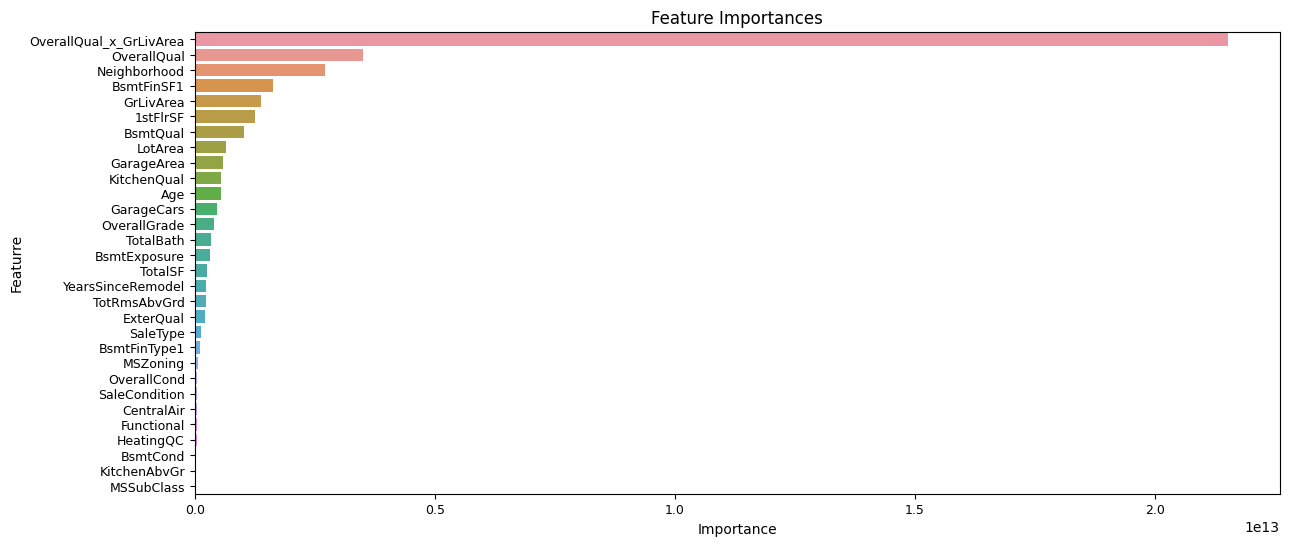

In [436]:
#特徴量の重要度を可視化させている。なお、もってくる特徴量の変数は、モデルの計算用に使用した、x_tr(テストデータ用の説明変数である)
#なお、MSsubclassは 数値型であるが、実質的にはカテゴリ変数のため、その数字に意味を持たないので、重要度が低くなっている。（必ず変換して意味を持たせる必要あり）
imp_df = pd.DataFrame({
    "features": x_tr.columns,
    "imp": model.feature_importances_
})
imp_df = imp_df.sort_values(by="imp", ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(x="imp", y="features", data=imp_df.head(30))
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Featurre")

plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()

## **提出用のデータフレームに整形する

In [437]:
#作成したモデルで、x_test を 計算（model.predict(x_test) の部分）し、これを  y_test_pred にいれている。
y_test_pred = model.predict(x_test)

df_submit = pd.DataFrame({
    'Id': test.Id,
    'SalePrice': y_test_pred
})
df_submit.head(10)

,Id,SalePrice
0,1461,130162.285340
1,1462,161700.917302
2,1463,169627.354923
3,1464,182771.796934
4,1465,187478.905057
5,1466,172507.140184
6,1467,181190.336260
7,1468,168373.839756
8,1469,180686.099948
9,1470,131786.482491


## **CSVファイルを出力する。

In [438]:
df_submit.to_csv("hp-submission_toriaeze20250830.csv", index=False)

In [439]:
#KitchenAbvG 単体でカテゴリー変換しても、精度は悪くなる可能性がある。（２０２５年６月２４日）